<h1 style="text-align: center;">Sleeping score / Regression V1</h1>

<h1 style="text-align: center;"><a id="table_contents">Table of contents</a></h1>
<ul>
<h3><li><a href="#introduction">1. Introduction</a></li></h3>
<h3><li><a href="#data_wrangling">2. Data Wrangling</a></li></h3>
    <ul>
        <h4><li><a href="#dataset_explanations">2.1. Dataset explanations</a></li></h4>
        <h4><li><a href="#data_preprocessing">2.2. Data preprocessing</a></li></h4>
    </ul>
<h3><li><a href="#eda">3. Exploratory Data Analysis</a></li></h3>
<h3><li><a href="#modeling">4. Modeling</a></li></h3>
<h3><li><a href="#conclusion">5. Conclusion</a></li></h3>
</ul>

In [81]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import mlflow
import mlflow.sklearn

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, RFE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.metrics import get_scorer_names, mean_squared_error, mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline

import xgboost
from xgboost import XGBRegressor

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8888")

# Create a new MLflow Experiment
# mlflow.set_experiment("Sleeping_score")

Do 1 model of regression to predict sleeping score (classic ML + NN)

And 1 model of classification to predict quality score (try to build a solid neural network)

<a id='introduction'></a>
# 1. Introduction 
<a href="#table_contents">Table of contents</a>
<hr>
This machine learning project leverages four datasets sourced from a friend's Garmin Connect account.    

The datasets include daily records of sports activities, heart rate, calories consumption, and nightly sleep data. The goal of the project is to predict a sleeping score, on a scale from 0 to 100, using the provided data.

By analyzing patterns and correlations between physical activities, max heart rate during the day, calories consumed and sleep quality, the model aims to offer insights into factors that most significantly impact sleep. The predictive model will aid in optimizing lifestyle choices to enhance overall sleep quality.
<hr>

Activities dataframe columns explanations :
- Aerobic TE : As provided by Garmin, the training effect is a measure that provides informations about the effect on our physicial condition.    
This Training Effect is between 0 and 5, with :
    - 0 to 0.9 : No improvement
    - 1 to 1.9 : Little improvement
    - 2 to 2.9 : Maintain
    - 3 to 3.9 : Improvement
    - 4 to 4.9 : Great improvement
    - 5 : Objective exceeded

#### Statistical functions

In [184]:
def rmse_score(y_true, y_pred, as_int: bool = True, form: str = ':.4f'):
    """ Compute the RMSE """
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    if as_int:
        return rmse
    return f"{rmse:.4f}"

def mae_score(y_true, y_pred, as_int : bool = True):
    """ Compute the MAE """

    mae = mean_absolute_error(y_true, y_pred)

    if as_int:
        return mae
    return f"{mae:.4f}"

def r2_r2_adjust_score(y_true, y_pred, X_df, as_int : bool = True):
    """ Compute the R2 and Adjusted R2 """

    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X_df.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    if as_int:
        return r2, adjusted_r2
    return f"{r2:.4f}", f"{adjusted_r2:.4f}"


def regression_metrics(y_true, y_pred, X_df):
    """ Return regression metrics RMSE, MAE, R2 and Adjusted_R2 
    
    Parameters :
    ------------
    * y_true : True values
    * y_pred : Predicted values 

    Output : 
    --------
    * tuples : (rmse, mae, r2, adjusted_r2)

    Example :
    ---------
    >>> regression_metrics(y_test, y_pred) -> (0.1, 0.08, 0.85, 0.83)
    """
    rmse = rmse_score(y_true, y_pred)
    mae = mae_score(y_true, y_pred)
    r2, adjusted_r2 = r2_r2_adjust_score(y_true, y_pred, X_df)
    return rmse, mae, r2, adjusted_r2

def wilcoxon_mann_whithney(pop, sample):
    """ Compute the U and p_value for Mann Whitney Wilcoxon test """
    U, p = stats.mannwhitneyu(pop, sample)
    return U, p

def assert_p_value(p_value: float = None, thresh: int = 0.05):
    """ Assert if there is a statistical difference based on the p_value and the set threshold """
    print(f"p_value : {p_value:.4f} -> Statistically different") if p_value < thresh else print(f"p_value : {p_value:.4f} -> Not statistically different")


def print_wmh_results(influential_df, whole_df, normal_df, col_name):
    print("High influential VS whole dataset Wilcoxon Mann Whitney test")
    _, mann_p = wilcoxon_mann_whithney(influential_df[col_name], whole_df[col_name])
    print(f"p_value : {mann_p:.4f} -> Statistically different\n") if mann_p < 0.05 else print(f"p_value : {mann_p:.4f} -> Not statistically different\n")

    print('"Normal data" vs whole dataset Wilcoxon Mann Whitney test')
    _, mann_p = wilcoxon_mann_whithney(normal_df[col_name], whole_df[col_name])
    print(f"p_value : {mann_p:.4f} -> Statistically different") if mann_p < 0.05 else print(f"p_value : {mann_p:.4f} -> Not statistically different")


#### Model-related functions

##### Linear Regression

In [4]:
def mlflow_linreg(lr_model: LinearRegression, perf_dict: dict, run_name: str = None):
    """ Save the model and the associated metrics within an mlflow run """
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_metric("train_rmse", perf_dict['lr_rmse_train'])
        mlflow.log_metric("test_rmse", perf_dict['lr_rmse_test'])
        mlflow.log_metric("train_mae", perf_dict['lr_mae_train'])
        mlflow.log_metric("test_mae", perf_dict['lr_mae_test'])
        mlflow.log_metric("Train_R2", perf_dict['lr_r2_train'])
        mlflow.log_metric("Test_R2", perf_dict['lr_r2_test'])
        mlflow.log_metric("Train_Adjusted_R2", perf_dict['lr_adjusted_r2_train'])
        mlflow.log_metric("Test_Adjusted_R2", perf_dict['lr_adjusted_r2_test'])
        mlflow.sklearn.log_model(lr_model, "Linear_regression")

In [5]:
def lin_reg_train_test(X_train: pd.DataFrame = None, X_test: pd.DataFrame = None, y_train: pd.Series = None, y_test: pd.Series = None,
                       mlflow_reg: bool = False, run_name: str = None, **kwargs) -> tuple[LinearRegression, dict]:
    """ Train and return the linear regression + the associated performances.
    If mlflow_reg = True then register the model and the score in mlflow 
    
    Parameters :
    ------------
    * X_train, X_test : pd.DataFrame
        train and test dataframes
    * y_train, y_test : np.array, vector, pd.Series
        train and test target values
    * mlflow_reg : bool
        True : Register the run with mlflow
    * run_name : str
        run_name of the mlflow run

    Returns :
    --------
    (model, perf_dict)

    Example :
    ---------
    >>> lin_reg_train_test(X_train, X_test, y_train, y_test, mlflow_reg=True, run_name="Base linear regression model")
    """
    perf_dict = {}

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    lr_y_hat_train = lr.predict(X_train)

    perf_dict['lr_rmse_train'], perf_dict['lr_mae_train'], perf_dict['lr_r2_train'], perf_dict['lr_adjusted_r2_train'] = regression_metrics(y_train, lr_y_hat_train, X_train)

    lr_y_hat_test = lr.predict(X_test)

    perf_dict['lr_rmse_test'], perf_dict['lr_mae_test'], perf_dict['lr_r2_test'], perf_dict['lr_adjusted_r2_test'] = regression_metrics(y_test, lr_y_hat_test, X_test)

        # if mlflow_reg:
        #     mlflow_linreg(lr_model=lr, perf_dict=perf_dict, run_name=run_name)

    return lr, perf_dict

# 2. Data Wrangling <a id='data_wrangling'></a>
<a href="#table_contents">Table of contents</a>

## 2.1 Dataset explanations <a id='dataset_explanations'></a>
<hr>

<h4><b><u>Activities Dataset :</u></b></h4>

- <u>Type</u> : Activity type, e.g. running, cycling, swimming, etc...
- <u>Date</u> : Date of the activity
- <u>Activity_distance</u> : Distance of the activity in kilometers (or meters for swimming)
- <u>Activity_calories</u> : Calories consumed during activity
- <u>Duration</u> : Total duration of the activity (hh:mm:ss)
- <u>Activity_average_heart_rate</u> : Average heart rate during the activity
- <u>Activity_maximum_heart_rate</u> : Maximum heart rate reached during the activity
- <u>Aerobic</u> TE : As provided by Garmin, the training effect is a measure that provides informations about the effect on our physicial condition. 
    This Training Effect is between 0 and 5, with :
    - 0 to 0.9 : No improvement
    - 1 to 1.9 : Little improvement
    - 2 to 2.9 : Maintain
    - 3 to 3.9 : Improvement
    - 4 to 4.9 : Great improvement
    - 5 : Objective exceeded
- <u>Average_running_cadence</u> : Only presents in running activity, represent the average steps by minutes
- <u>Maximum_running_cadence</u> : Only presents in running activity, represent the maximum steps by minutes reached
- <u>Average_pace</u> : Average pace during the activity. 
    - min/km for running
    - km/h for cycling
    - min/100m for swimming
- <u>Best_pace</u> : Best pace reached during the activity.
- <u>Maximum_temperature</u> : Maximum outside temperature recorded by the watch during the activity.
- <u>Activity_minimum_respiratory_frequency</u> : Minimum respiratory frequency recorded during activity. In breathing/minutes.
- <u>Activity_average_respiratory_frequency</u> : Average respiratory frequency recorded during activity. In breathing/minutes.
- <u>Activity_maximum_respiratory_frequency</u> : Maximum respiratory frequency recorded during activity. In breathing/minutes.
- <u>Travel_time</u> : Time spent in movement during the activity (hh:mm:ss)
- <u>Elapsed_time</u> : Total time of the activity (hh:mm:ss)
- <u>Minimum_altitude</u> : Minimum altitude recorded by the watch during the activity.
- <u>Maximum_altitude</u> : Maximum altitude recorded by the watch during the activity.
<hr>
<h4><b><u>Calories Dataset :</u></b></h4>

- <u>Date</u> : Date associated
- <u>Active_calories</u> : Calories consumed in activity
- <u>Resting_calories</u> : Base calories consumption of the body
- <u>Total_calories</u> : Total calories consumed during the day, sum of the active calories and resting calories.
<hr>
<h4><b><u>Heart rate Dataset :</u></b></h4>

- <u>Date</u> : Date associated
- <u>Resting_HR</u> : Heart rate when the body is at rest, usually when we are sleeping or lying in bed after waking up. <a style="color: rgb(255,0,0)"><b>This variable is automatically eliminated as it is recorded during sleep.</b></a>
- <u>Highest_HR</u> : Highest reached heart rate of the day.
<hr>
<h4><b><u>Sleep Dataset</u></b></h4>

- <u>Score</u> : Represents a sleeping score on a scale from 0 to 100, that represents how well we slept.
- <u>Date</u> : Wake-up date. Meaning that all the other dataset are shifted by one day in relation to this dataset.
- <u>Base_HR</u> : Heart rate when the body is at rest, usually when we are sleeping or lying in bed after waking up.
- <u>HRV</u> (Heart Rate Variability) : The HRV represents the variation in time between consecutive heartbeats.  HRV is a great indicator of the balance between the activity of the two branches of the autonomic nervous system. It is an indirect measurement of stress, higher HRV means lower stress. It is also used to determine sleep stages. (source : https://support.garmin.com/en-US/?faq=04pnPSBTYSAYL9FylZoUl5)
- <u>Quality</u> : The quality is highly related to score as it is bins of the latter.
    - Poor : 0 - 59
    - Fair : 60 - 79
    - Good : 80 - 89
    - Excellent : 90 - 100
- <u>Sleep_duration</u> : Time spent sleeping.
- <u>Bedtime</u> : Time we fell asleep. (hh:mm)
- <u>Waking_hour</u> : Wake-up time. (hh:mm)  <a style="color: rgb(255,0,0)"><b>This variable is automatically eliminated as it is a result of sleep.</b></a>

In [6]:
activities_vars = ["Type d'activité", "Date", "Distance", "Calories", "Durée", "Fréquence cardiaque moyenne", "Fréquence cardiaque maximale",
                   "TE aérobie", "Cadence de course moyenne", "Cadence de course maximale", "Allure moyenne", "Meilleure allure",
                   "Température maximale", "Fréquence respiratoire moyenne", "Fréquence respiratoire minimale", "Fréquence respiratoire maximale",
                   "Temps de déplacement", "Temps écoulé", "Altitude minimale", "Altitude maximale"]

activities_vars_eng = ["Type", "Date", "Activity_distance", "Activity_calories", "Duration", "Activity_average_heart_rate", "Activity_maximum_heart_rate",
                       "Aerobic_TE", "Average_running_cadence", "Maximum_running_cadence", "Average_pace", "Best_pace",
                       "Maximum_temperature", "Activity_average_respiratory_frequency", "Activity_minimum_respiratory_frequency", "Activity_maximum_respiratory_frequency",
                       "Travel_time", "Elapsed_time", "Minimum_altitude", "Maximum_altitude"]

In [7]:
activities_vars_rename = dict(zip(activities_vars, activities_vars_eng))

In [8]:
# Import activities data and rename variables in english
activities = pd.read_csv("Data/Activities.csv", sep=",", header=0, encoding="utf8", na_values='--')
activities = activities[activities_vars]
activities = activities.rename(columns=activities_vars_rename)
print(activities.shape)
activities.head(3)

(380, 20)


,Type,Date,Activity_distance,Activity_calories,Duration,Activity_average_heart_rate,Activity_maximum_heart_rate,Aerobic_TE,Average_running_cadence,Maximum_running_cadence,Average_pace,Best_pace,Maximum_temperature,Activity_average_respiratory_frequency,Activity_minimum_respiratory_frequency,Activity_maximum_respiratory_frequency,Travel_time,Elapsed_time,Minimum_altitude,Maximum_altitude
0,Course à pied,2024-05-09 15:49:57,9.45,720,00:49:25,162,193,3.9,161.0,172.0,5:14,3:58,29.0,33.0,19.0,42.0,00:48:16,00:49:25,34.0,53
1,Course à pied,2024-05-08 18:40:10,7.33,522,00:43:53,133,151,2.5,159.0,190.0,5:59,5:04,26.0,26.0,14.0,34.0,00:43:24,00:43:54,45.0,58
2,Course à pied,2024-05-07 18:48:17,1.44,106,00:07:15.2,148,174,2.1,162.0,221.0,5:03,3:55,26.0,NaN,NaN,NaN,00:06:55.3,00:07:15.2,41.0,52


In [9]:
# Import calories data and rename variables in english
calories = pd.read_csv("Data/Calories_pv.csv", sep=";", header=0, encoding="latin1")
calories = calories.rename(columns={"Calories actives": "Active_calories",
                                    "Calories au repos": "Resting_calories",
                                    "Calories dépensées au total": "Total_calories"})
print(calories.shape)
calories.head(3)

(487, 4)


,Date,Active_calories,Resting_calories,Total_calories
0,15 Avr.,772,"1,837","2,609"
1,14 Avr.,"1,491","2,187","3,678"
2,13 Avr.,620,"2,187","2,807"


In [10]:
# Import heart rate data and rename variables in english
hr = pd.read_csv("Data/FC.csv", sep=";", header=0, encoding="utf8", na_values="--")
hr = hr.rename(columns={"Repos": "Resting_HR",
                        "Le plus haut": "Highest_HR"})
print(hr.shape)
hr.head(3)

(470, 3)


,Date,Resting_HR,Highest_HR
0,16 Avr.,52 bpm,69 bpm
1,15 Avr.,52 bpm,167 bpm
2,14 Avr.,61 bpm,142 bpm


In [11]:
# Import sleep data and rename variables in english
sleep = pd.read_csv("Data/Sommeil.csv", sep=",", header=0, encoding="utf8", na_values="--")

sleep_list = [pd.read_csv(f"Data/Sommeil ({idx}).csv", sep=",", header=0, encoding="utf8", na_values="--") for idx in range(1, 17+1)]
sleep_list.insert(0, sleep) # Put the latest data at the beginning of the list

sleep = pd.concat(sleep_list)
sleep = sleep.rename(columns={"Score de sommeil 4\xa0semaines": "Date",
                              "Fréquence cardiaque au repos": "Base_HR",
                              "Statut de la variabilité de la fréquence cardiaque": "HRV",
                              "Qualité": "Quality",
                              "Durée": "Sleep_duration",
                              "Heure de coucher": "Bedtime",
                              "Heure de lever": "Waking_hour"}).drop(columns="Oxymètre de pouls")

sleep = sleep[["Date", "Score", "Quality", "Sleep_duration", "Bedtime", "Waking_hour"]]

print(sleep.shape)
sleep.head(3)


(504, 6)


,Date,Score,Quality,Sleep_duration,Bedtime,Waking_hour
0,15 Avr.,89.0,Bon,8h 4min.,23:26,7:31
1,14 Avr.,41.0,Mauvais,7h 6min.,3:23,10:39
2,13 Avr.,74.0,Passable,8h 30min.,23:08,8:20


## 2.2. Data preprocessing <a id="data_preprocessing"></a>
<a href="#table_contents">Table of contents</a>

### Activities dataset

In [12]:
# Convert to datetime type the Date column
activities['Date'] = pd.to_datetime(activities['Date']).dt.date
activities['Date'] = pd.to_datetime(activities['Date']) # convert back to datetime64[ns] instead of float

In [13]:
activities.head(3)

,Type,Date,Activity_distance,Activity_calories,Duration,Activity_average_heart_rate,Activity_maximum_heart_rate,Aerobic_TE,Average_running_cadence,Maximum_running_cadence,Average_pace,Best_pace,Maximum_temperature,Activity_average_respiratory_frequency,Activity_minimum_respiratory_frequency,Activity_maximum_respiratory_frequency,Travel_time,Elapsed_time,Minimum_altitude,Maximum_altitude
0,Course à pied,2024-05-09,9.45,720,00:49:25,162,193,3.9,161.0,172.0,5:14,3:58,29.0,33.0,19.0,42.0,00:48:16,00:49:25,34.0,53
1,Course à pied,2024-05-08,7.33,522,00:43:53,133,151,2.5,159.0,190.0,5:59,5:04,26.0,26.0,14.0,34.0,00:43:24,00:43:54,45.0,58
2,Course à pied,2024-05-07,1.44,106,00:07:15.2,148,174,2.1,162.0,221.0,5:03,3:55,26.0,NaN,NaN,NaN,00:06:55.3,00:07:15.2,41.0,52


### Calories dataset

In [14]:
month_dict = {"jan.": 1, "fév.": 2, "mar.": 3, "avr.": 4, "mai": 5, "juin": 6, "juil": 7, "août": 8, "sep.": 9, "oct": 10, "nov.": 11, "déc.": 12}

In [15]:
def get_day(row, date_var, month_dict):
    """ Retrieve the day of the Date variables in the dataframes """

    if len(row[date_var].split('-')) > 1:
        splitted_date = row[date_var].split('-')
        day = splitted_date[0].lstrip('0')
        return day
    else:
        splitted_date = row[date_var].split(' ')
        day = splitted_date[0]
        return day
    

def get_month(row, date_var, month_dict):
    """ Retrieve the month number of the Date variables in the dataframes """
    
    if len(row[date_var].split('-')) > 1:
        splitted_date = row[date_var].split('-')
        month = month_dict[splitted_date[1].lower()]
        return month
    else:
        splitted_date = row[date_var].split(' ')
        month = month_dict[splitted_date[1].lower()]
        return month
    
def new_date(row):
    """ Use the newly created Year, Month and Day to create the new Date in Datetime64[ns] with format YYYY-MM-DD """
    
    return pd.to_datetime(f"{int(row['Year'])}-{str(row['Month']).zfill(2)}-{str(row['Day']).zfill(2)}")

In [16]:
# Initiailize columns
calories['Day'] = np.zeros(calories.shape[0])
calories['Month'] = np.zeros(calories.shape[0])
calories['Year'] = np.zeros(calories.shape[0])

calories['Day'] = calories.apply(lambda row: get_day(row, 'Date', month_dict), axis=1)
calories['Month'] = calories.apply(lambda row: get_month(row, 'Date', month_dict), axis=1)
# Manually set the years 
calories.loc[467:, 'Year'] = 2022
calories.loc[:102, 'Year'] = 2024

calories['Year'] = np.where(calories['Year'] == 0, 2023, calories['Year'])
calories["Date"] = calories.apply(lambda row: new_date(row), axis=1)

calories = calories.drop(columns=['Day', 'Month', 'Year'])

In [17]:
calories.head(3)

,Date,Active_calories,Resting_calories,Total_calories
0,2024-04-15,772,"1,837","2,609"
1,2024-04-14,"1,491","2,187","3,678"
2,2024-04-13,620,"2,187","2,807"


### HR Dataset

In [18]:
# Initiailize columns
hr['Day'] = np.zeros(hr.shape[0])
hr['Month'] = np.zeros(hr.shape[0])
hr['Year'] = np.zeros(hr.shape[0])

# Manually set the years
hr.loc[451:, 'Year'] = 2022
hr.loc[:99, 'Year'] = 2024
hr['Year'] = np.where(hr['Year'] == 0, 2023, hr['Year'])

hr['Month'] = hr.apply(lambda row: get_month(row, 'Date', month_dict), axis=1)
hr['Day'] = hr.apply(lambda row: get_day(row, 'Date', month_dict), axis=1)

# Create the new date variable
hr["Date"] = hr.apply(lambda row: new_date(row), axis=1)

hr = hr.drop(columns=['Day', 'Month', 'Year'])

In [19]:
hr.head(3)

,Date,Resting_HR,Highest_HR
0,2024-04-16,52 bpm,69 bpm
1,2024-04-15,52 bpm,167 bpm
2,2024-04-14,61 bpm,142 bpm


### Sleep dataset

In [20]:
# The first 15 days the watch didn't record any score
sleep = sleep.reset_index(drop=True).loc[:len(sleep)-15, :] 

# We remove rows where we don't have a sleeping score as we won't be able to use them further.
sleep = sleep.loc[sleep['Score'].notna(), :].reset_index(drop=True)

In [21]:
# Create 3 new columns that receive Day, Month and Year of the Date column
sleep['Day'] = np.zeros(sleep.shape[0])
sleep['Month'] = np.zeros(sleep.shape[0])
sleep['Year'] = np.zeros(sleep.shape[0])

sleep.loc[:87, 'Year'] = 2024
sleep.loc[389:, 'Year'] = 2022

# If year is still 0 then it is 2023
sleep['Year'] = np.where(sleep['Year'] == 0, 2023, sleep['Year'])

# Retrieve Month and Day from the Date
sleep['Month'] = sleep.apply(lambda row: get_month(row, 'Date', month_dict), axis=1)
sleep['Day'] = sleep.apply(lambda row: get_day(row, 'Date', month_dict), axis=1)

# Convert Date to the wanted datetime format
sleep["Date"] = sleep.apply(lambda row: new_date(row), axis=1)


In [22]:
# sleeping score for a day correspond do the night from day-1 to day.
# Night of 15th of April is a result of activities of 14th of April
# So to compare effects of activities of the day we have to substract one day to every sleep data
sleep['Date'] = sleep['Date'] - pd.Timedelta(days=1)

sleep = sleep.drop(columns=['Day', 'Month', 'Year'])

## Merged dataframes

In [23]:
merged_1 = pd.merge(sleep, activities, how='left', on='Date')
merged_2 = pd.merge(merged_1, hr, how='left', on='Date')
df_merged = pd.merge(merged_2, calories, how='left', on='Date').drop(columns=['Resting_HR'])

In [24]:
df_merged.head(3)

,Date,Score,Quality,Sleep_duration,Bedtime,Waking_hour,Type,Activity_distance,Activity_calories,Duration,...,Activity_minimum_respiratory_frequency,Activity_maximum_respiratory_frequency,Travel_time,Elapsed_time,Minimum_altitude,Maximum_altitude,Highest_HR,Active_calories,Resting_calories,Total_calories
0,2024-04-14,89.0,Bon,8h 4min.,23:26,7:31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,142 bpm,"1,491","2,187","3,678"
1,2024-04-13,41.0,Mauvais,7h 6min.,3:23,10:39,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,126 bpm,620,"2,187","2,807"
2,2024-04-12,74.0,Passable,8h 30min.,23:08,8:20,Course à pied,3.00,217,00:20:28,...,NaN,NaN,00:20:03,00:20:28,40.0,52,152 bpm,607,"2,187","2,794"


In [25]:
# Label Encoding on quality
print(f"Quality missing values : {df_merged['Quality'].isnull().mean()}")

qualities = [['Mauvais', 'Passable', 'Bon', 'Excellent']]

quality_OE = OrdinalEncoder(categories=qualities)
quality_OE.fit(np.array(df_merged['Quality']).reshape(-1, 1))

df_merged['Quality'] = quality_OE.transform(np.array(df_merged['Quality']).reshape(-1, 1))

Quality missing values : 0.0


In [26]:
for qual, number in zip(quality_OE.categories_[0] ,quality_OE.transform(np.array(quality_OE.categories_).reshape(-1, 1))):
    print(f"{qual} : {number[0]}")

Mauvais : 0.0
Passable : 1.0
Bon : 2.0
Excellent : 3.0


In [27]:
def sleep_duration_in_hours_minutes(row):
    """ Convert sleep duration from xh ymin. to hours,minutes """

    if not isinstance(row['Sleep_duration'], (int, float)):
        h, minutes = row['Sleep_duration'].split(' ')
        return float(h.strip('h')) + float(minutes.strip('min.')) / 60

def bed_related_to_minutes(row, bed_col):
    """ Convert bed related columns from hh:mm to hours,minutes """
    
    if not isinstance(row[bed_col], float):
        h, minutes = row[bed_col].split(':')
        return float(h) + float(minutes) / 60

In [28]:
# Convert sleep duration in minutes
print(f"Sleep duration missing values : {df_merged['Sleep_duration'].isnull().mean()}")

df_merged['Sleep_duration'] = df_merged.apply(lambda row: sleep_duration_in_hours_minutes(row), axis=1)

# Remove rows where Bedtime is NaN, as we further compute a sleeping duration variable
df_merged = df_merged.loc[df_merged['Bedtime'].notna()].reset_index(drop=True)
print(f"Bedtime missing values : {df_merged['Bedtime'].isnull().mean()}")

df_merged['Bedtime'] = df_merged.apply(lambda row: bed_related_to_minutes(row, 'Bedtime'), axis=1)
df_merged['Waking_hour'] = df_merged.apply(lambda row: bed_related_to_minutes(row, 'Waking_hour'), axis=1)

Sleep duration missing values : 0.0
Bedtime missing values : 0.0


In [29]:
# Initialize the new Awake time variable
df_merged['Awake_time'] = np.NaN

# Calculate the awake time be computing the difference between the Waking_hour of day d-1 and the bedtime of day d
for i in range(1, len(df_merged)):
    waking_prev_day = df_merged.at[i-1, 'Waking_hour']
    bedtime_curr_day = df_merged.at[i, 'Bedtime']
    # If the bedtime is after midnight we add 24
    if 0 < bedtime_curr_day < 10:
        bedtime_curr_day += 24
    df_merged.at[i, 'Awake_time'] = np.abs(waking_prev_day - bedtime_curr_day)

df_merged['Awake_time'] = np.where(pd.isna(df_merged['Awake_time']), df_merged['Awake_time'].mean(), df_merged['Awake_time'])

In [30]:
# Type selections and label encoding
df_merged['Type'] = np.where(pd.isna(df_merged['Type']), 'No_activities', df_merged['Type'])
type_part = df_merged['Type'].value_counts(dropna=False).reset_index()

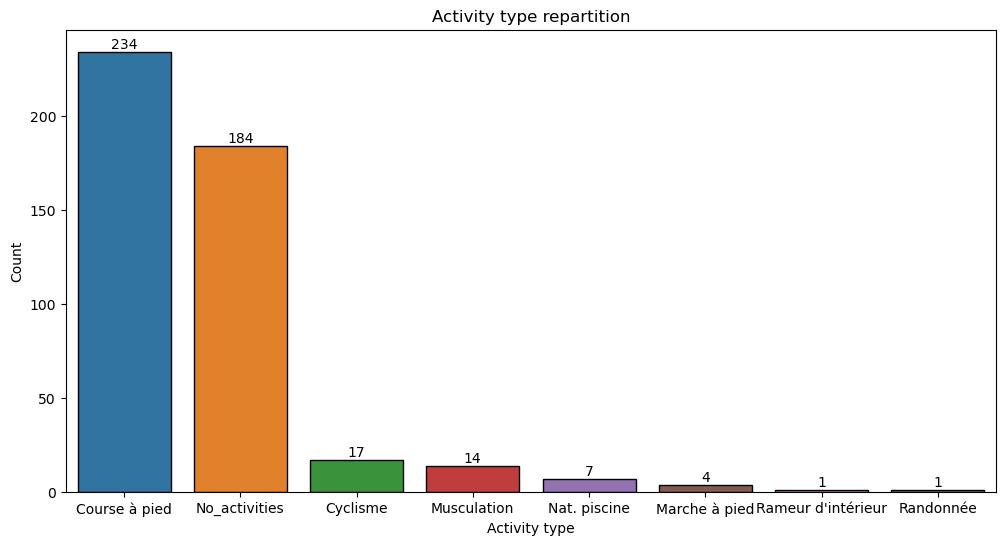

In [31]:
plt.figure(figsize=(12, 6))
bars = sns.barplot(data=type_part, x='index', y='Type', edgecolor='black')
plt.title("Activity type repartition")
plt.xlabel("Activity type")
plt.ylabel("Count")

for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.show()

Thanks to the above plot, I choose to erase the following activities as they represents nothing : walk (Marche à pied), Indoor rower (Rameur d'intérieur) and Hiking (Randonnée).

I replace them by a "No_activities" 

In [32]:
to_remplace_types = ["Marche à pied", "Rameur d'intérieur", "Randonnée"]

df_merged['Type'] = np.where(df_merged['Type'].isin(to_remplace_types), 'No_activities', df_merged['Type'])

In [33]:
def convert_distance(row):
    """ Convert distance from string to float, with a results expressed in km """
    
    if row['Activity_distance'] != 0:
        # If activity is swimming and less than 1km were swimmed
        if row['Type'] == 'Nat. piscine' and not "," in row['Activity_distance']:
            return float(row['Activity_distance']) / 1000
        
        if "," in row['Activity_distance']:
            return float(row['Activity_distance'].replace(",", "."))
        
        return float(row['Activity_distance'])
    return 0

In [34]:
# Replace missing values by 0
df_merged['Activity_distance'] = np.where(pd.isna(df_merged['Activity_distance']), 0, df_merged['Activity_distance'])

df_merged['Activity_distance'] = df_merged.apply(lambda row: convert_distance(row), axis=1)

print(f"Activity distance missing values : {df_merged['Activity_distance'].isnull().mean()}")

Activity distance missing values : 0.0


In [35]:
def convert_calories(row, cal_var):
    """ Convert calories to integers """
    
    if not pd.isna(row[cal_var]) and not isinstance(row[cal_var], (float, int)):
        # handles cases where the calories finish by a 0 and the 0 is therefore truncated
        # So we have to append 0 at the end while the calories is not format 1,234
        if "," in row[cal_var] and len(row[cal_var]) != 5:
            while len(row[cal_var]) < 5:
                row[cal_var] += '0'

        # if there is a coma in calories meaning that it is greater than 1 000 then we delete
        # the coma. In the case where calories < 1000 where there's no coma, it's still transformed in integer
        return int(row[cal_var].replace(",", ""))
    
    return 0

In [36]:
calories_cols = ['Activity_calories', 'Active_calories', 'Resting_calories', 'Total_calories']  

# Replace by 0 rows where there is no activity and therefore no activity calories
df_merged['Activity_calories'] = np.where(pd.isna(df_merged['Activity_calories']), 0, df_merged['Activity_calories'])

for col in calories_cols:
    df_merged[col] = df_merged.apply(lambda row: convert_calories(row, col), axis=1)
    print(f"{col} missing values : {df_merged[col].isnull().mean()}")

# Handle cases where total calories is perfectly round like 3000
df_merged['Total_calories'] = np.where(df_merged['Total_calories'] <= 9, df_merged['Total_calories'] * 1000, df_merged['Total_calories'])

Activity_calories missing values : 0.0
Active_calories missing values : 0.0
Resting_calories missing values : 0.0
Total_calories missing values : 0.0


In [37]:
def durations_to_minutes(row, duration_var):
    """ Convert columns that represents a duration in minutes """
    
    if not pd.isna(row[duration_var]):
        h, m, s = row[duration_var].split(':')
        return int(h) * 60 + int(m) + float(s) / 60
    return 0

In [38]:
durations_cols = ['Duration', 'Travel_time', 'Elapsed_time']

for col in durations_cols:
    df_merged[col] = df_merged.apply(lambda row: durations_to_minutes(row, col), axis=1)
    print(f"{col} missing values : {df_merged[col].isnull().mean()}")

Duration missing values : 0.0
Travel_time missing values : 0.0
Elapsed_time missing values : 0.0


In [39]:
def pace_to_minutes_pace(row, pace_col):
    """ Convert pace to minutes,seconds / km """

    if not pd.isna(row[pace_col]):
        # For cycling the pace is expressed as km/h
        if row['Type'] == 'Cyclisme':
            return 60 / float(row[pace_col])
        
        # For swimming the pace is expressed as mm:ss / 100m
        elif row['Type'] == 'Nat. piscine':
            m, s = row[pace_col].split(':')
            return (int(m) + float(s) / 60) * 10

        else:
            m, s = row[pace_col].split(':')
            return int(m) + float(s) / 60
            
    return 0

In [40]:
pace_cols = ['Average_pace', 'Best_pace']

for col in pace_cols:
    df_merged[col] = df_merged.apply(lambda row: pace_to_minutes_pace(row, col), axis=1)

In [41]:
def convert_altitude(row):
    """ Convert altitude to integers """

    if not pd.isna(row['Maximum_altitude']):
        # Sometimes the watch records surprising altitude data, so we replace them by 0
        if int(row['Maximum_altitude'].replace(",", "")) < 0 or int(row['Maximum_altitude'].replace(",", "")) > 500:
            return 0
        
        else:
            return int(row['Maximum_altitude'])
        
    return 0

In [42]:
# Convert altitude
df_merged['Maximum_altitude'] = df_merged.apply(lambda row: convert_altitude(row), axis=1)
print(f"Maximum_altitude missing values : {df_merged['Maximum_altitude'].isnull().mean()}")

Maximum_altitude missing values : 0.0


In [43]:
def convert_HR(row, hr_col):
    """ Convert heart rate related columns to integers """
    
    if not pd.isna(row[hr_col]):

        return int(row[hr_col].strip(" bpm"))

In [44]:
hr_columns = ['Highest_HR']

for col in hr_columns:
    df_merged[col] = df_merged.apply(lambda row: convert_HR(row, col), axis=1)
    print(f"{col} missing values : {df_merged[col].isnull().mean()}")

Highest_HR missing values : 0.0021645021645021645


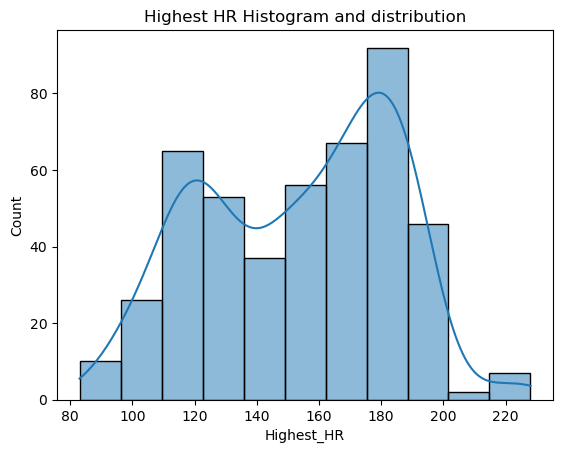

In [45]:
sns.histplot(data=df_merged, x='Highest_HR', kde=True)
plt.title('Highest HR Histogram and distribution')

plt.show()

In [46]:
# The Highest HR missing value represents 1 row so I've decided to remove it
df_merged = df_merged.loc[df_merged['Highest_HR'].notna()].reset_index(drop=True)

In [47]:
# Where there is no activity and therefore no aerobic TE, we replace NaN by 0
df_merged['Aerobic_TE'] = np.where(pd.isna(df_merged['Aerobic_TE']), 0, df_merged['Aerobic_TE'])

<hr>
When i merged the dataframe, I've initially done a left join on sleep dataset.

Sleep dataset contains **1 rows per date**, but the activities dataset contains 1 row <u>**per activity**</u>, so in the merged dataframe i've got multiples same sleeping data for one date but multiple activity for this date.

The following part handles 2 cases :

1. We have multiple activities for the same date, with at least 2 different activities
2. We have multiple activities for the same date, but it's the same activity that has been repeated

In both case we create a new variable that represents the number of different activities done this day, and we compute the sum for duration, distance and aerobic TE.

In [48]:
# Create a new dataframe that contains multiplied date
m_date = pd.DataFrame(df_merged['Date'].value_counts()).reset_index()
m_date = m_date.loc[m_date['Date'] > 1]

In [49]:
# Create a dataframe that contains the number of unique activities, per date
unique_act = df_merged.groupby('Date')['Type'].nunique().reset_index()
# Contains date that have at least 2 different activities
mult_act = unique_act.loc[unique_act['Type'] > 1]

In [50]:
# Retrieve the date where there is at least 2 activity types
mult_act_date = [date for date in mult_act['Date'].tolist() if date in m_date['index'].tolist()]
mult_act_date_n_type = mult_act['Type'].tolist()

# multiplied dates but that has multiplie activities of the unique same type
unique_act_date = [date for date in m_date['index'] if date not in mult_act_date]

len(mult_act_date), len(unique_act_date)

(27, 8)

In [51]:
df_merged['N_activities'] = np.zeros(df_merged.shape[0])

# set N_activities for multiplied dates with at least 2 activity types
for idx, date in enumerate(mult_act_date):
    df_merged.loc[df_merged['Date'] == date, 'N_activities'] = mult_act_date_n_type[idx]

# Set N_activities for multiplied dates but with 1 activity type
for date in unique_act_date:
    df_merged.loc[df_merged['Date'] == date, 'N_activities'] = 1

In [52]:
# Where date are not mutliplied therefore we set n_activities to 1
df_merged['N_activities'] = np.where((df_merged['Type'] != 'No_activities') & (df_merged['N_activities'] == 0), 1, df_merged['N_activities'])

In [53]:
df_merged['Total_duration'] = np.zeros(df_merged.shape[0])
df_merged['Total_distance'] = np.zeros(df_merged.shape[0])
df_merged['Total_aerobic_TE'] = np.zeros(df_merged.shape[0])

In [54]:
# sums distance duration and aerobic TE for the multiple activities date
to_sum_cols = ['Activity_distance', 'Duration', 'Aerobic_TE']

for date in mult_act_date + unique_act_date:
    dist, dur, te = df_merged.loc[df_merged['Date'] == date, to_sum_cols].sum()
    df_merged.loc[df_merged['Date'] == date, 'Total_distance'] = dist
    df_merged.loc[df_merged['Date'] == date, 'Total_duration'] = dur
    df_merged.loc[df_merged['Date'] == date, 'Total_aerobic_TE'] = te

In [55]:
df_merged['Total_duration'] = np.where(df_merged['Total_duration'] == 0, df_merged['Duration'], df_merged['Total_duration'])
df_merged['Total_distance'] = np.where(df_merged['Total_distance'] == 0, df_merged['Activity_distance'], df_merged['Total_distance'])
df_merged['Total_aerobic_TE'] = np.where(df_merged['Total_aerobic_TE'] == 0, df_merged['Aerobic_TE'], df_merged['Total_aerobic_TE'])

In [56]:
# Now we keep only one row for the duplicated dates
df_merged = df_merged.drop_duplicates(subset='Date', keep='first').reset_index(drop=True)

In [57]:
to_drop_cols = ['Type', 'Duration', 'Activity_distance', 'Activity_calories', 'Average_pace', 'Best_pace', 'Maximum_temperature',
'Activity_minimum_respiratory_frequency', 'Travel_time', 'Elapsed_time', 'Active_calories', 'Resting_calories', 'Activity_average_heart_rate',
'Activity_maximum_heart_rate', 'Average_running_cadence', 'Maximum_running_cadence', 'Activity_average_respiratory_frequency',
'Activity_maximum_respiratory_frequency', 'Minimum_altitude', 'Maximum_altitude', 'Resting_HR', 'Aerobic_TE', 'Waking_hour']

In [58]:
miss_vals = df_merged.select_dtypes(include='number').isnull().mean()
miss_vals_cols = miss_vals[miss_vals > 0].index

for col in miss_vals_cols:
    df_merged[col] = np.where(pd.isna(df_merged[col]), 0, df_merged[col])

df_merged.isnull().mean()

Date                                      0.0
Score                                     0.0
Quality                                   0.0
Sleep_duration                            0.0
Bedtime                                   0.0
Waking_hour                               0.0
Type                                      0.0
Activity_distance                         0.0
Activity_calories                         0.0
Duration                                  0.0
Activity_average_heart_rate               0.0
Activity_maximum_heart_rate               0.0
Aerobic_TE                                0.0
Average_running_cadence                   0.0
Maximum_running_cadence                   0.0
Average_pace                              0.0
Best_pace                                 0.0
Maximum_temperature                       0.0
Activity_average_respiratory_frequency    0.0
Activity_minimum_respiratory_frequency    0.0
Activity_maximum_respiratory_frequency    0.0
Travel_time                       

In [59]:
quality_le = LabelEncoder()
quality_le.fit(df_merged['Type'].unique())

for sport, numb in zip(quality_le.classes_, quality_le.transform(['Course à pied', 'Cyclisme', 'Musculation', 'Nat. piscine', 'No_activities'])):
    print(f"{sport} : {numb}")

df_merged['Type'] = quality_le.transform(df_merged['Type'])

Course à pied : 0
Cyclisme : 1
Musculation : 2
Nat. piscine : 3
No_activities : 4


In [113]:
df_merged = df_merged.drop(columns=['Waking_hour'])

### Baseline model with all features

In [114]:
X_base = df_merged.drop(columns=['Date', 'Score', 'Quality'])
Y_base = df_merged['Score']

In [115]:
random_state = 42
test_size = 0.25

lr_base = LinearRegression()

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

base_cv_results = cross_validate(lr_base, X_base, Y_base, cv=skf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), return_train_score=True)

In [116]:
np.sqrt(np.abs(cross_val_score(lr_base, X_base, Y_base, cv=5, scoring='neg_mean_squared_error'))).mean()

13.258776018296293

In [117]:
base_train_rmse_full = base_cv_results['train_neg_mean_squared_error']
base_test_rmse_full = base_cv_results['test_neg_mean_squared_error']

base_train_rmse = np.sqrt(np.abs(base_train_rmse_full)).mean()
base_test_rmse = np.sqrt(np.abs(base_test_rmse_full)).mean()

print(f"Base train RMSE : {base_train_rmse} | stddev : {np.std(base_train_rmse_full)}")
print(f"Base test RMSE : {base_test_rmse} | stddev : {np.std(base_test_rmse_full)}")

Base train RMSE : 10.880550890278275 | stddev : 5.725968208969817
Base test RMSE : 12.007048138448626 | stddev : 16.037090344051087


### Selecting features

#### SelectKBest
<hr>
The following cell runs the SelectKBest algorithm, starting by taking all the features and deleting them one by one.

Then, a plot shows the training and testing RMSE evolution based on the number of features

Finally, a correlation matrix is displayed to see how features interacts with each others.

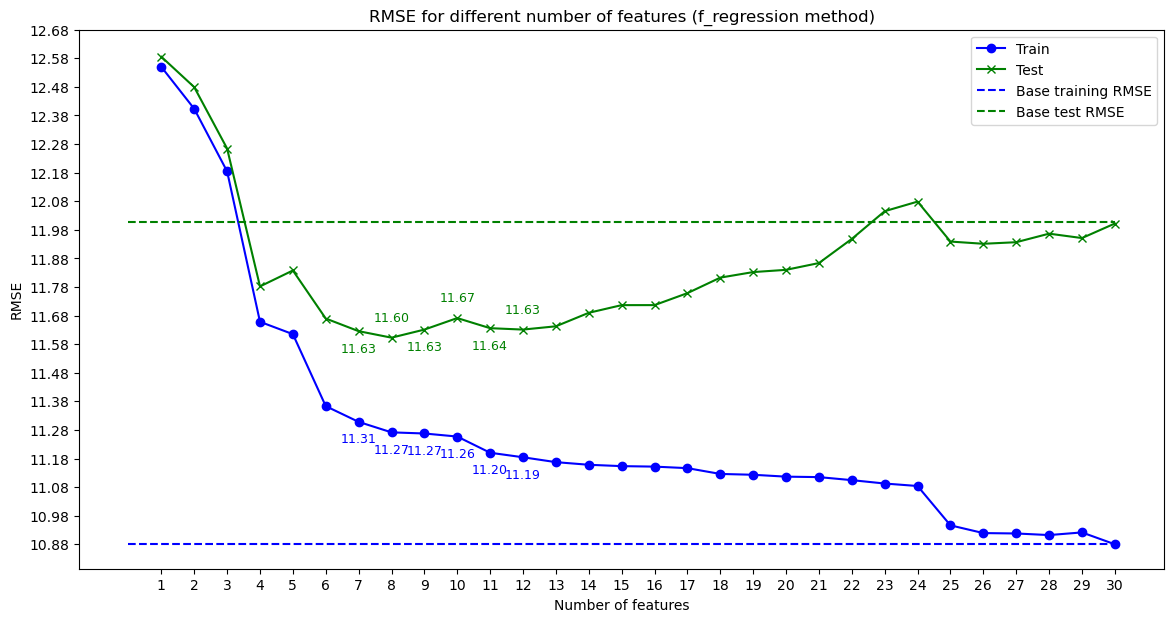

In [143]:
train_metric_values, test_metric_values = [], []
f_reg_k_best_features_dict = {}

random_state = 42
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

lr_test = LinearRegression()

max_features = X_base.shape[1]

for i in range(max_features, 0, -1):
    # INITIALISE KBest
    k = i
    kbest = SelectKBest(score_func=f_regression, k=k)
    kbest.fit(X_base, Y_base)
    
    # Create a dict with score, feature a key, values
    scores, features = kbest.scores_, kbest.feature_names_in_
    feature_score_dict = dict(zip(scores, features))

    k_best_feat_score = sorted(scores)[-k:]
    k_best_features = []

    # Retrieve the KBest feature names
    for score in k_best_feat_score:
        k_best_features.append(feature_score_dict[score])
    # Dictionnary that retrieve every set of features for each KBest 
    f_reg_k_best_features_dict[k] = k_best_features

    X_kbest = df_merged[k_best_features]
    Y_kbest = df_merged['Score']

    # Run a StratifiedKFold Cross Validation
    cv_results = cross_validate(lr_test, X_kbest, Y_kbest, cv=skf, scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'), return_train_score=True)

    train_metric_values.append(np.sqrt(np.abs(cv_results['train_neg_mean_squared_error'])).mean())
    test_metric_values.append(np.sqrt(np.abs(cv_results['test_neg_mean_squared_error'])).mean())

plt.figure(figsize=(14, 7))
plt.plot(range(max_features, 0, -1), train_metric_values, marker='o', label='Train', color='blue')
plt.plot(range(max_features, 0, -1), test_metric_values, marker='x', label='Test', color='green')
plt.hlines(y=base_train_rmse, xmin=0, xmax=max_features, linestyles='--', label='Base training RMSE', colors='blue')
plt.hlines(y=base_test_rmse, xmin=0, xmax=max_features, linestyles='--', label='Base test RMSE', colors='green')
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.xticks([i for i in range(1, max_features+1, 1)])

y_min, y_max = min(min(train_metric_values), min(test_metric_values)), max(max(train_metric_values), max(test_metric_values)) 
steps = 0.1

plt.yticks(np.arange(y_min, y_max + steps, steps))
plt.title('RMSE for different number of features (f_regression method)')
plt.legend()

features_to_annotate = [7, 8, 9, 10, 11, 12]

for feature in features_to_annotate:
    index = max_features - feature
    test_neg = -1 if (feature % 2) else 0.8
    plt.annotate(f'{test_metric_values[index]:.2f}', 
                 (feature, test_metric_values[index]), 
                 textcoords="offset points", 
                 xytext=(0, test_neg * 15), 
                 ha='center', 
                 fontsize=9, 
                 color='green')
    plt.annotate(f'{train_metric_values[index]:.2f}', 
                 (feature, train_metric_values[index]), 
                 textcoords="offset points", 
                 xytext=(0,-15), 
                 ha='center', 
                 fontsize=9, 
                 color='blue')

plt.show()

#### Recursive Feature Elimination

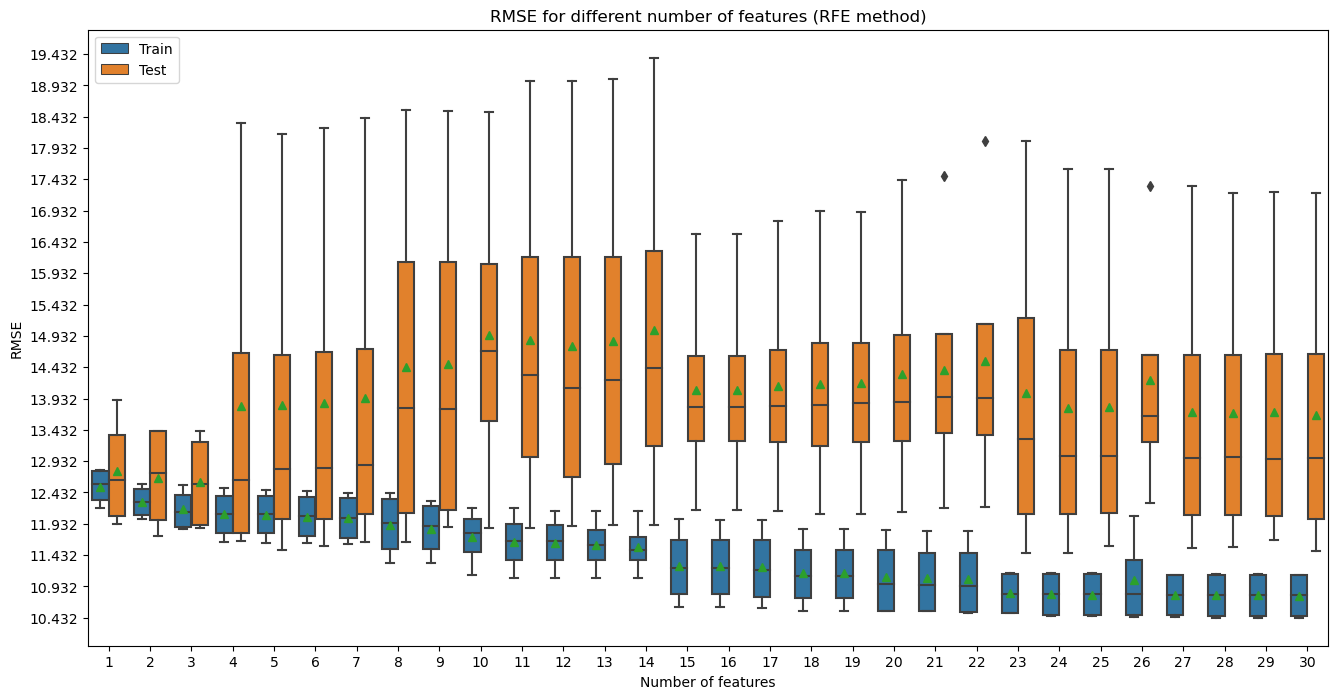

In [152]:
score_dict = {}
cv = 4
rmse_train_results, rmse_test_results, names = [], [], []

for i in range(1, X_base.shape[1]+1, 1):
    rfe_lr = LinearRegression()
    rfe = RFE(estimator=rfe_lr, n_features_to_select=i)
    

    scores_tmp = cross_validate(rfe, X_base, Y_base, scoring=('neg_mean_squared_error', 'r2'), cv=cv, n_jobs=-2, return_train_score=True)
    rmse_train_results.append(np.sqrt(np.abs(scores_tmp['train_neg_mean_squared_error'])))
    rmse_test_results.append(np.sqrt(np.abs(scores_tmp['test_neg_mean_squared_error'])))

    names.append(i)

train_results = []
for i, rmse_train in enumerate(rmse_train_results):
    for val in rmse_train:
        train_results.append({'Features': names[i], 'RMSE': val, 'Type': 'Train'})

test_results = []
for i, rmse_test in enumerate(rmse_test_results):
    for val in rmse_test:
        test_results.append({'Features': names[i], 'RMSE': val, 'Type': 'Test'})

results_df = pd.DataFrame(train_results + test_results)

# Plot using seaborn
plt.figure(figsize=(16, 8))
sns.boxplot(x='Features', y='RMSE', hue='Type', data=results_df, showmeans=True)
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.title('RMSE for different number of features (RFE method)')

y_min, y_max = min(np.min(rmse_train_results), np.min(rmse_test_results)), max(np.max(rmse_train_results), np.max(rmse_test_results)) 
steps = 0.5

plt.yticks(np.arange(y_min, y_max + steps, steps))
plt.legend(loc='upper left')
plt.show()

In [153]:
rfe_features = []

rfe_lr = LinearRegression()
rfe = RFE(estimator=rfe_lr, n_features_to_select=8)
rfe.fit(X_base, Y_base)

for sup, col in zip(rfe.support_, X_base.columns):
    if sup:
        print(col)
        rfe_features.append(col)

Sleep_duration
Bedtime
Type
Activity_average_respiratory_frequency
Activity_maximum_respiratory_frequency
Awake_time
N_activities
Total_aerobic_TE


### Model with feature selection results

In [155]:
# Retrieves the common columns for both techniques
common_cols = [col for col in f_reg_k_best_features_dict[k] if col in rfe_features]
# Retrieves the columns that are present for one technique but absent of the other one and reverse
not_shared_cols = [col for col in f_reg_k_best_features_dict[k] if col not in rfe_features] + [col for col in rfe_features if col not in f_reg_k_best_features_dict[k]]
# Creates the list that contains all the columns
interest_cols = common_cols + not_shared_cols

In [156]:
# Replace Score at the first place in the list
i, j = interest_cols.index('Score'), interest_cols.index(interest_cols[0])
interest_cols[i], interest_cols[j] = interest_cols[j], interest_cols[i]

In [157]:
# Sets our working dataframe with our previously selected columns 
df_work = df_merged[interest_cols]

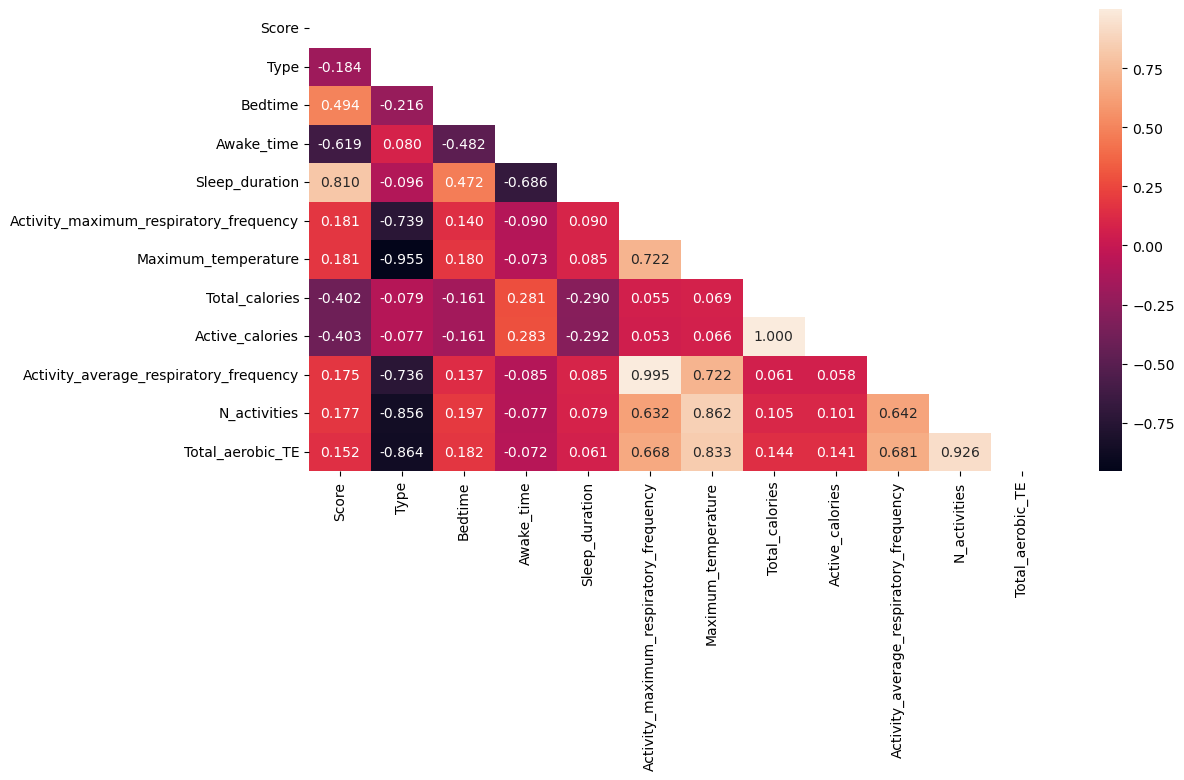

In [158]:
# Generate a diagonal correlation matrix
corr = df_work.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt='.3f')
plt.show()

In [159]:
lr_work = LinearRegression()
X = df_work[[col for col in df_work.columns if 'Score' not in col]]
y = df_work['Score']

random_state = 42
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)

work_cv_resuls = cross_validate(
    estimator=lr_work,
    X=X,
    y=y,
    cv=skf,
    scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'),
    return_train_score=True
)

work_train_rmse_full = work_cv_resuls['train_neg_mean_squared_error']
work_test_rmse_full = work_cv_resuls['test_neg_mean_squared_error']

work_train_rmse = np.sqrt(np.abs(work_train_rmse_full)).mean()
work_test_rmse = np.sqrt(np.abs(work_test_rmse_full)).mean()

print(f"Work train RMSE : {work_train_rmse} | Base train RMSE : {base_train_rmse} | Diff : {work_train_rmse - base_train_rmse} | stddev : {np.std(work_train_rmse_full)}")
print(f"Work test RMSE : {work_test_rmse} | Base test RMSE : {base_test_rmse} | Diff : {work_test_rmse - base_test_rmse} | stddev : {np.std(work_test_rmse_full)}")

Work train RMSE : 11.193950696241545 | Base train RMSE : 10.880550890278275 | Diff : 0.3133998059632699 | stddev : 5.409383782110006
Work test RMSE : 11.572705935394064 | Base test RMSE : 12.007048138448626 | Diff : -0.4343422030545625 | stddev : 14.92768407440779


The model with selected variables performs the same as the baseline model.

Let's explore the data and see how we can improve it.

# 3.Exploratory Data Analysis <a id='eda'></a>
<a href="#table_contents">Table of contents</a>

## Score

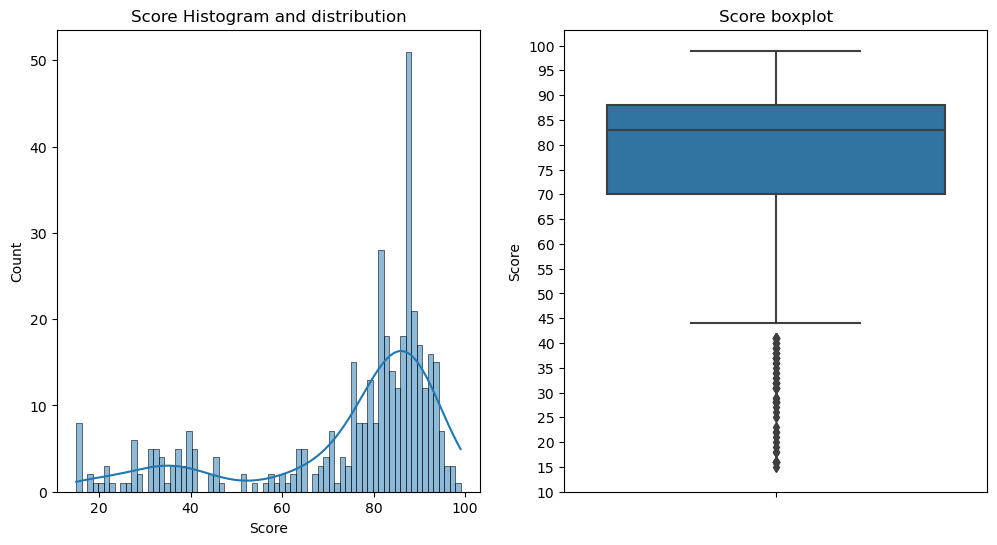

In [147]:
bins = df_work['Score'].nunique()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df_work, x='Score', kde=True, bins=bins, ax=axs[0])
axs[0].set_title('Score Histogram and distribution')

sns.boxplot(data=df_work, y='Score', ax=axs[1])
axs[1].set_title('Score boxplot')
axs[1].set_yticks([i for i in range(10, 100+5, 5)])

plt.show()

## Type and N_activities

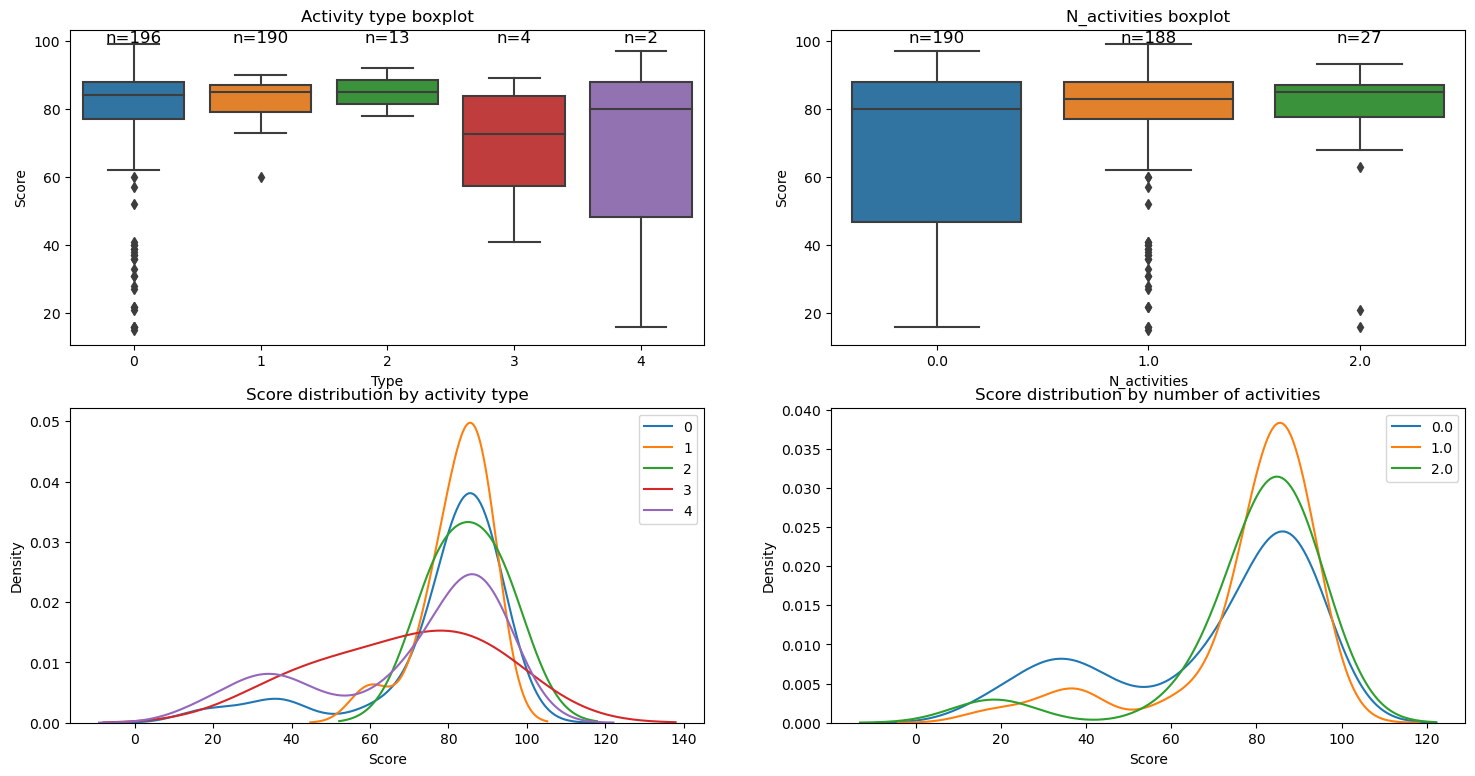

In [200]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9))

# Type boxplot
sns.boxplot(data=df_work, x='Type', y='Score', ax=axs[0, 0])
axs[0,0].set_title('Activity type boxplot')

group_sizes = df_work['Type'].value_counts()

for i, group in enumerate(group_sizes.index):
    size = group_sizes[group]# Positioning above the boxplot
    axs[0, 0].text(i, 103, f'n={size}', ha='center', va='top', fontsize=12, color='black')

# Type kdeplot
for i in sorted(df_work['Type'].unique()):
    sns.kdeplot(data=df_work.loc[df_work['Type'] == i], x='Score', label=i, ax=axs[1, 0])
axs[1, 0].legend()
axs[1, 0].set_title('Score distribution by activity type')



# N_activities boxplot
sns.boxplot(data=df_work, x='N_activities', y='Score', ax=axs[0, 1])
axs[0, 1].set_title('N_activities boxplot')

group_sizes = df_work['N_activities'].value_counts()

for i, group in enumerate(group_sizes.index):
    size = group_sizes[group]# Positioning above the boxplot
    axs[0, 1].text(i, 103, f'n={size}', ha='center', va='top', fontsize=12, color='black')

# N_activities kdeplot
for i in df_work['N_activities'].unique():
    sns.kdeplot(data=df_work.loc[df_work['N_activities'] == i], x='Score', label=i, ax=axs[1, 1])
axs[1, 1].legend()
axs[1, 1].set_title('Score distribution by number of activities')

plt.show()

As we can see, the distribution curves are not normal, so we'll use the Kruskal-Willis test to see if there are any statistical differences between the different Type and N_activities groups.
<hr>
Let's start by Type

In [186]:
groups = [df_work.loc[df_work['Type'] == i, 'Score'] for i in df_work['Type'].unique()]
kruskal_stat, p_value = stats.kruskal(*groups)

assert_p_value(p_value)

p_value : 0.0875 -> Not statistically different


No statistical difference but the groups are highly disproportionate.

Is there a difference between group 0 (No_activities) and group 1 (running) ?

In [208]:
groups = [df_work.loc[df_work['Type'] == i, 'Score'] for i in range(0, 1+1)]
kruskal_stat, p_value = stats.kruskal(*groups)

assert_p_value(p_value)

p_value : 0.9188 -> Not statistically different


It seems that whether or not an activity was performed during the day did not influence the score.
<hr>
What about N_activities

In [209]:
groups = [df_work.loc[df_work['N_activities'] == i, 'Score'] for i in df_work['N_activities'].unique()]
kruskal_stat, p_value = stats.kruskal(*groups)

assert_p_value(p_value)

p_value : 0.0312 -> Statistically different


As it is statistically different, we will now perform a Dunn's test to see wich group differs.

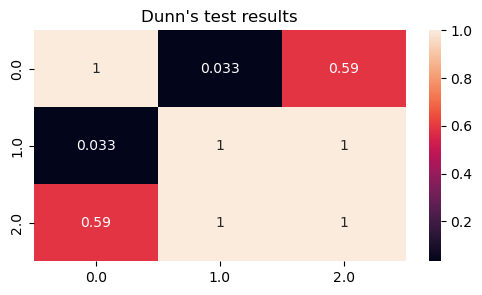

In [210]:
posthoc = sp.posthoc_dunn(df_work, val_col='Score', group_col='N_activities', p_adjust='bonferroni')
plt.figure(figsize=(6, 3))
sns.heatmap(posthoc, annot=True)
plt.title("Dunn's test results")
plt.show()

Thanks to the Dunn's test we can see that the group 1 statistically differs from the the group 0, and therefore groups 0 and 2 does not differs between them.

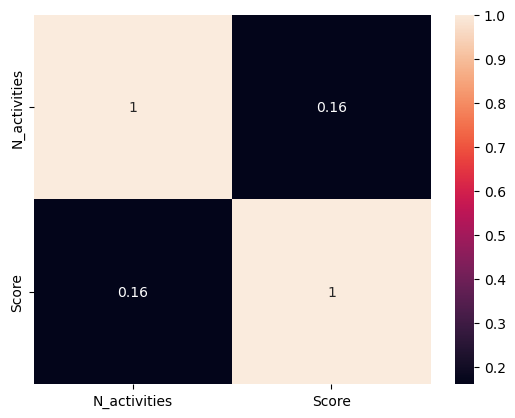

In [211]:
df_test = df_work[['N_activities', 'Score']]
df_test['N_activities'] = np.where(df_test['N_activities'] == 2, 0, df_test['N_activities'])
sns.heatmap(df_test.corr(), annot=True)
plt.show()

In [212]:
U, p_value = stats.mannwhitneyu(x=df_test.loc[df_test['N_activities'] == 0, 'Score'],
                                y=df_test.loc[df_test['N_activities'] == 1, 'Score'])

assert_p_value(p_value)

p_value : 0.0218 -> Statistically different


In [219]:
# Replace in df_work N_activities 2 by 0
df_work['N_activities'] = np.where(df_work['N_activities'] == 2, 0, df_work['N_activities'])
df_work['N_activities'].value_counts()

0.0    215
1.0    190
Name: N_activities, dtype: int64

As type is highly correlated with others features, and that there is no statistical difference between having or not performed an activity during the day, I will exclude this variable for modelization.

In [220]:
df_work = df_work.drop(columns=['Type'])

In [221]:
df_work.columns

Index(['Score', 'Bedtime', 'Awake_time', 'Sleep_duration',
       'Activity_maximum_respiratory_frequency', 'Maximum_temperature',
       'Total_calories', 'Active_calories',
       'Activity_average_respiratory_frequency', 'N_activities',
       'Total_aerobic_TE'],
      dtype='object')

### Bedtime, Awake_time and Sleep_duration

In [542]:
df_test = df_work[['Activity_maximum_heart_rate', 'Score']]

df_test['is_activity'] = np.where(df_test['Activity_maximum_heart_rate'] > 0, 1, 0)

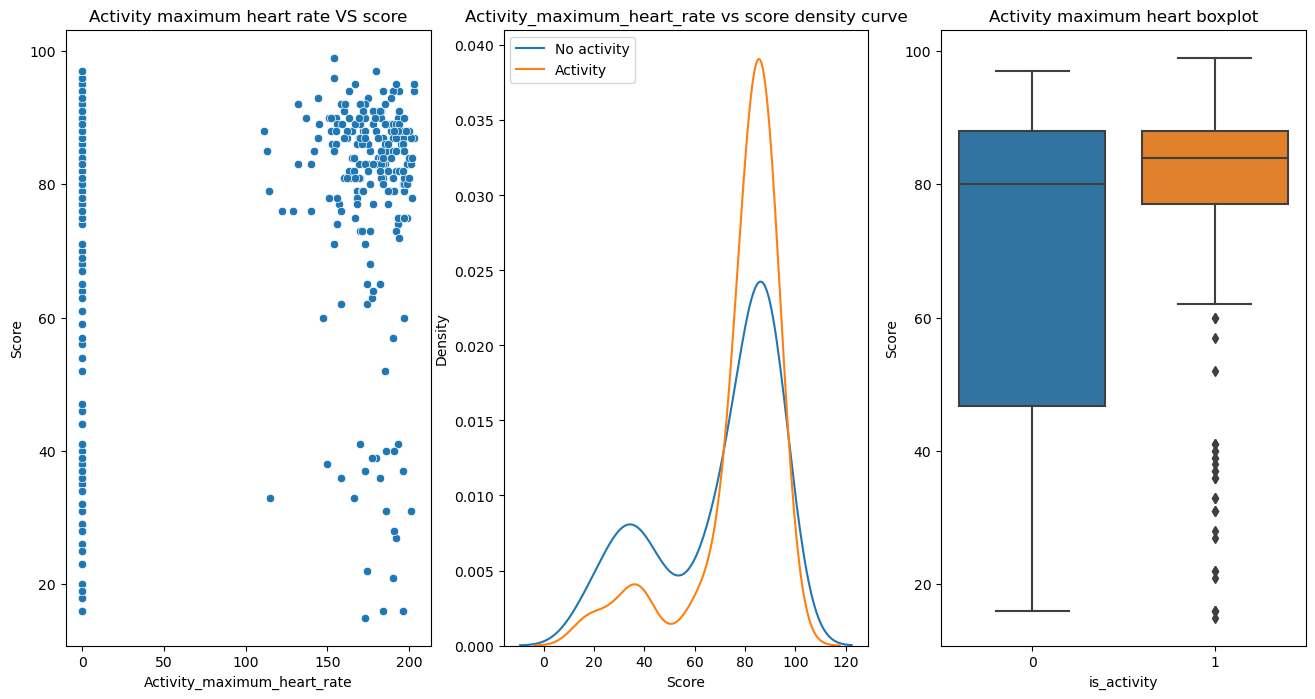

In [557]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.scatterplot(data=df_work, x='Activity_maximum_heart_rate', y='Score', ax=axs[0])
axs[0].set_title("Activity maximum heart rate VS score")

sns.kdeplot(data=df_work.loc[df_work['Activity_maximum_heart_rate'] == 0], x='Score', label='No activity', ax=axs[1])
sns.kdeplot(data=df_work.loc[df_work['Activity_maximum_heart_rate'] > 0], x='Score', label='Activity', ax=axs[1])
axs[1].legend()
axs[1].set_title('Activity_maximum_heart_rate vs score density curve')

sns.boxplot(data=df_test, x='is_activity', y='Score', ax=axs[2])
axs[2].set_title("Activity maximum heart boxplot")

plt.show()

### Sleep duration

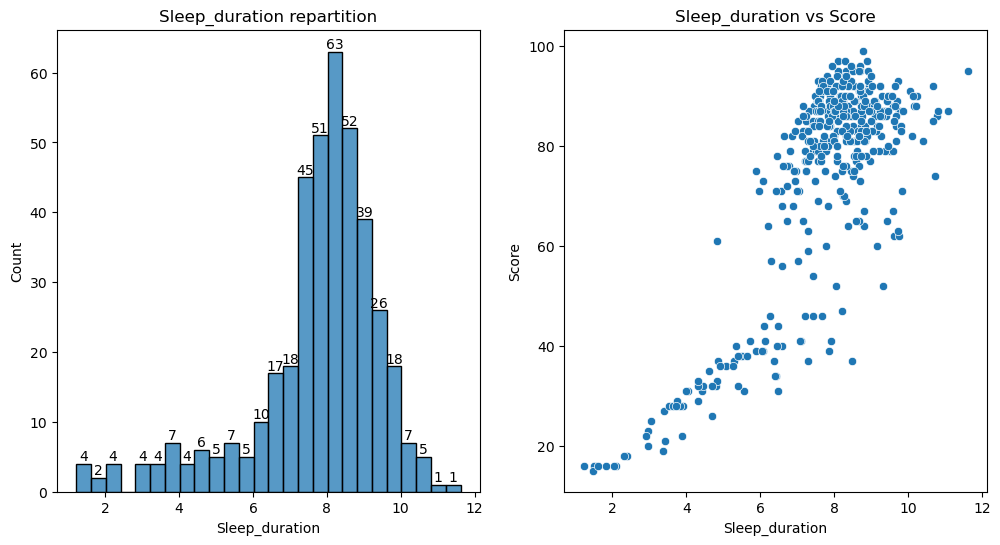

In [526]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

bars = sns.histplot(df_work['Sleep_duration'], ax=axs[0])
sns.scatterplot(data=df_work, x='Sleep_duration', y='Score', ax=axs[1])

axs[0].set_title('Sleep_duration repartition')
axs[1].set_title('Sleep_duration vs Score')

for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{int(height)}' if height else '',
        ha='center',
        va='bottom'
    )

plt.show()

### Bedtime

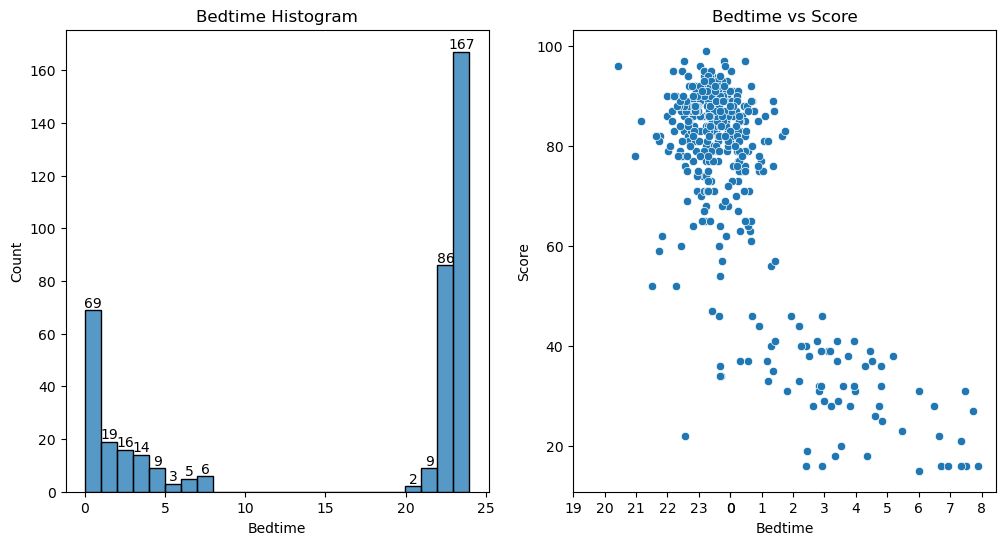

In [527]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

bars = sns.histplot(df_work['Bedtime'], bins=24, ax=axs[0])
axs[0].set_title('Bedtime Histogram')

# In order to have the bedtimes following on the graph we have to add 24 to them and play with the x label
adjusted_bedtime = df_work['Bedtime'].apply(lambda x: x + 24 if x < 8 else x)

sns.scatterplot(x=adjusted_bedtime, y=df_work['Score'], ax=axs[1])

xticks = list(range(19, 25)) + list(range(0, 9))  # 18-24 followed by 0-8
xtick_labels = ['19', '20', '21', '22', '23', '24', '0', '1', '2', '3', '4', '5', '6', '7', '8']
axs[1].set_xticks(ticks=list(range(19, 25)) + list(range(24, 33)), labels=xtick_labels)
axs[1].set_xlabel("Bedtime")
axs[1].set_ylabel("Score")
axs[1].set_title("Bedtime vs Score")

for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f'{int(height)}' if height else '',
        ha='center',
        va='bottom'
    )

plt.show()

### Total calories

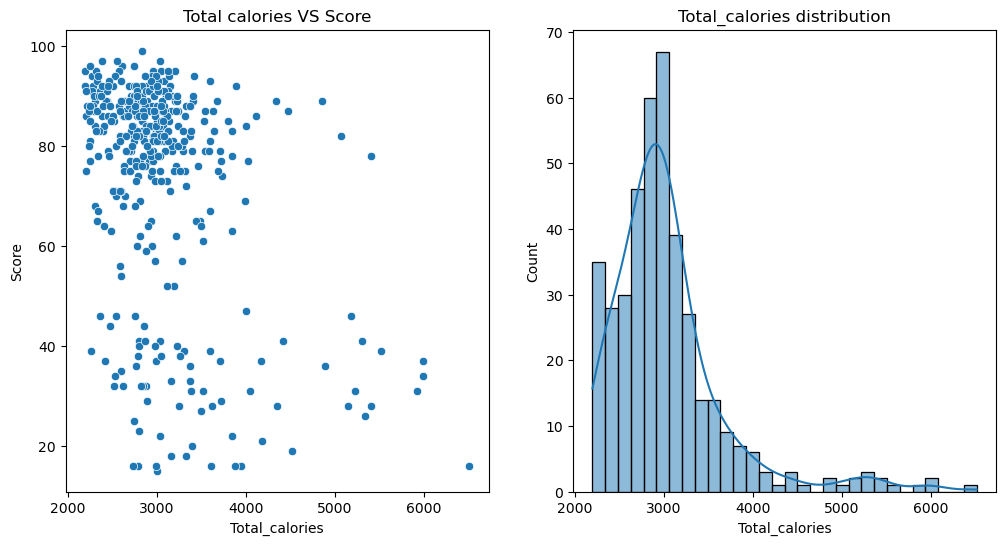

In [528]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=df_work, x='Total_calories', y='Score', ax=axs[0])
sns.histplot(data=df_work, x='Total_calories', kde=True, ax=axs[1])

axs[0].set_title('Total calories VS Score')
axs[1].set_title('Total_calories distribution')

plt.show()

### Awake time

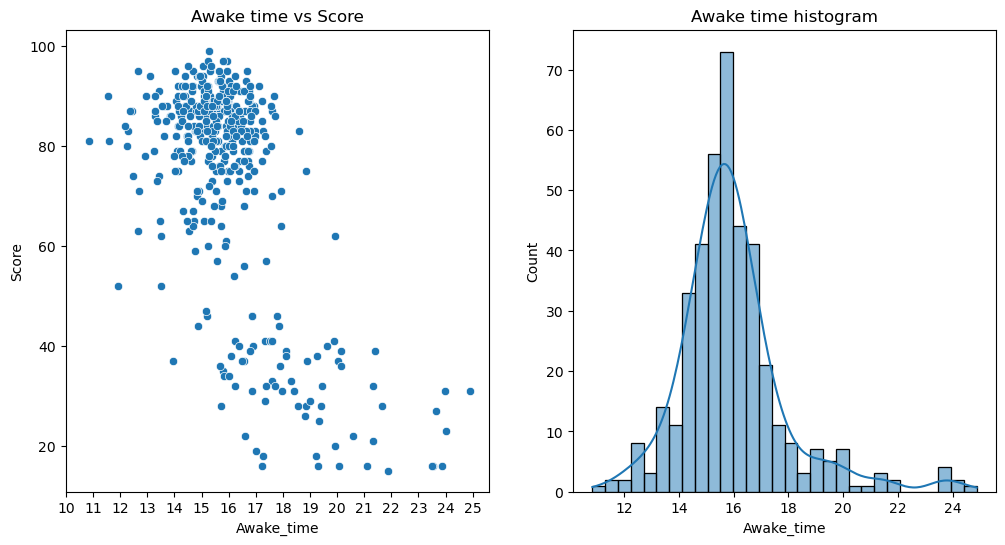

In [529]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=df_work, x='Awake_time', y='Score', ax=axs[0])
axs[0].set_xticks([i for i in range(int(df_work['Awake_time'].min()), int(df_work['Awake_time'].max())+2, 1)])
axs[0].set_title('Awake time vs Score')

sns.histplot(data=df_work, x='Awake_time', kde=True, ax=axs[1])
axs[1].set_title('Awake time histogram')

plt.show()

### N_activities

### Total_duration

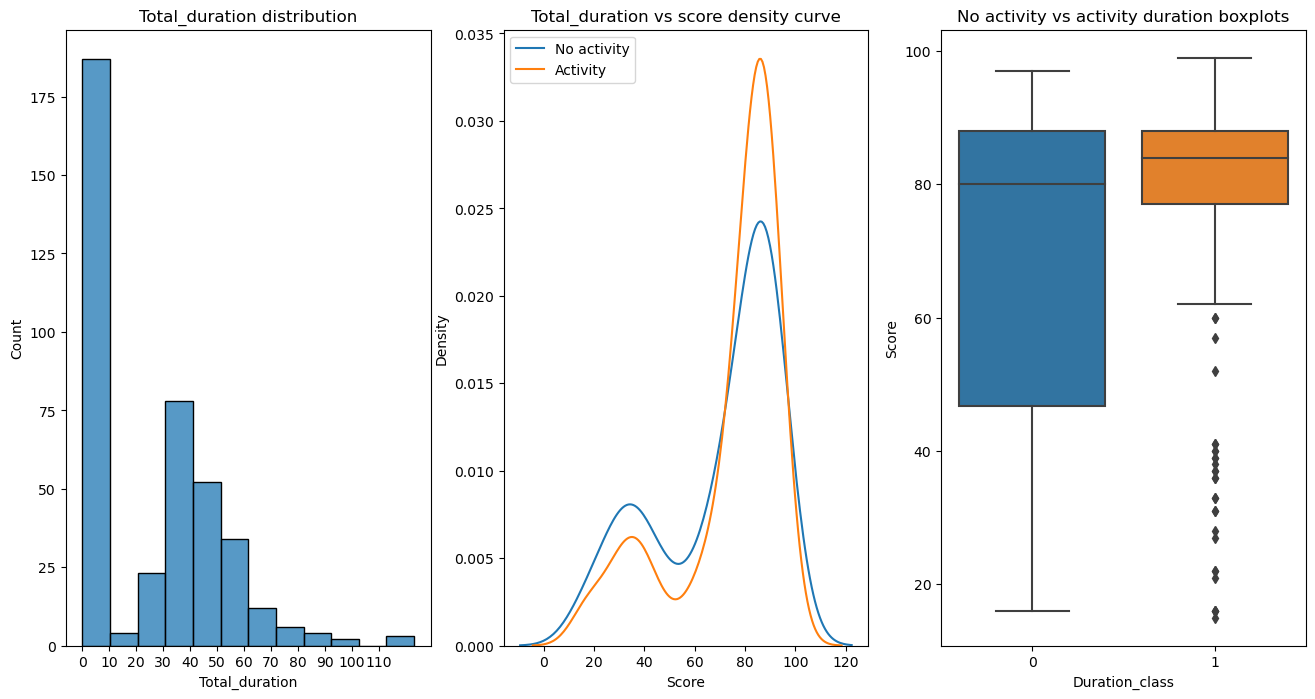

In [530]:
df_work_tmp = df_work.copy()
df_work_tmp['Duration_class'] = np.where(df_work_tmp['Total_duration'] == 0, 0, 1)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(data=df_work, x='Total_duration', ax=axs[0], bins=12)
axs[0].set_xticks([i for i in range(0, 120, 10)])
axs[0].set_title('Total_duration distribution')

sns.kdeplot(data=df_work.loc[df_work['Total_duration'] == 0], x='Score', label='No activity', ax=axs[1])
sns.kdeplot(data=df_work.loc[df_work['Total_duration'] != 1], x='Score', label='Activity', ax=axs[1])
axs[1].legend()
axs[1].set_title('Total_duration vs score density curve')

sns.boxplot(data=df_work_tmp, x='Duration_class', y='Score', ax=axs[2])
axs[2].set_title('No activity vs activity duration boxplots')

plt.show()

### Total_distance

In [531]:
df_work_tmp = df_work.copy()
df_work_tmp['Distance_class'] = np.where(df_work_tmp['Total_distance'] == 0, 0, 1)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(data=df_work, x='Total_distance', ax=axs[0])
# axs[0].set_xticks([i for i in range(0, 120, 10)])
axs[0].set_title('Total_distance distribution')

sns.kdeplot(data=df_work.loc[df_work['Total_distance'] == 0], x='Score', label='No activity', ax=axs[1])
sns.kdeplot(data=df_work.loc[df_work['Total_distance'] != 1], x='Score', label='Activity', ax=axs[1])
axs[1].legend()
axs[1].set_title('Total_distance vs score density curve')

sns.boxplot(data=df_work_tmp, x='Distance_class', y='Score', ax=axs[2])
axs[2].set_title('No activity vs activity distance boxplots')

plt.show()

KeyError: 'Total_distance'

### Total_aerobic_TE

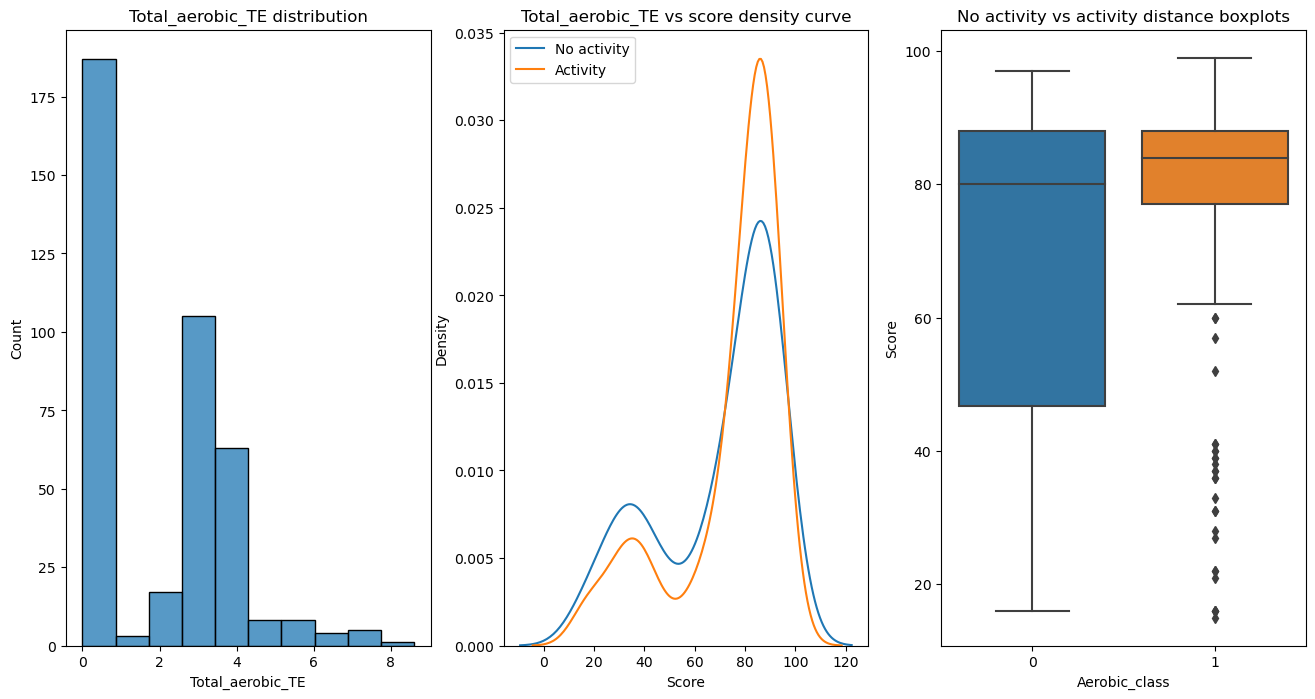

In [ ]:
df_work_tmp = df_work.copy()
df_work_tmp['Aerobic_class'] = np.where(df_work_tmp['Total_aerobic_TE'] == 0, 0, 1)

fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(data=df_work, x='Total_aerobic_TE', ax=axs[0])
# axs[0].set_xticks([i for i in range(0, 120, 10)])
axs[0].set_title('Total_aerobic_TE distribution')

sns.kdeplot(data=df_work.loc[df_work['Total_aerobic_TE'] == 0], x='Score', label='No activity', ax=axs[1])
sns.kdeplot(data=df_work.loc[df_work['Total_aerobic_TE'] != 1], x='Score', label='Activity', ax=axs[1])
axs[1].legend()
axs[1].set_title('Total_aerobic_TE vs score density curve')

sns.boxplot(data=df_work_tmp, x='Aerobic_class', y='Score', ax=axs[2])
axs[2].set_title('No activity vs activity distance boxplots')

plt.show()

# 4.Training Models

## Linear Models

In [ ]:
X = df_work[[col for col in df_work.columns if 'Score' not in col and "Quality" not in col]].drop(columns=['Date', 'Highest_HR'])
Y = df_work['Score']

In [ ]:
X

,Sleep_duration,Bedtime,Total_calories,Awake_time,N_activities,Total_duration,Total_distance,Total_aerobic_TE
0,8.066667,23.433333,3678,15.994360,0.0,0.000000,0.00,0.0
1,7.100000,3.383333,2807,19.866667,0.0,0.000000,0.00,0.0
2,8.500000,23.133333,2794,12.483333,1.0,20.466667,3.00,2.2
3,8.316667,22.800000,2741,14.466667,0.0,0.000000,0.00,0.0
4,7.216667,23.883333,3546,16.633333,1.0,51.700000,9.65,3.9
...,...,...,...,...,...,...,...,...
400,8.800000,23.150000,3602,14.700000,0.0,0.000000,0.00,0.0
401,10.100000,21.650000,3078,13.600000,1.0,63.383333,11.23,3.8
402,7.633333,20.983333,2341,12.933333,0.0,0.000000,0.00,0.0
403,8.466667,20.416667,2743,15.333333,1.0,37.750000,6.39,2.7


In [ ]:
random_state = 42
test_size = 0.25

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

In [ ]:
corr_lr, corr_perf_dict = lin_reg_train_test(X_train, X_test, y_train, y_test)

for key, val in corr_perf_dict.items():
    print(f"{key} : {val}")

lr_rmse_train : 11.7036
lr_mae_train : 9.5044
lr_r2_train : 0.7075
lr_adjusted_r2_train : 0.6996
lr_rmse_test : 10.5122
lr_mae_test : 8.4768
lr_r2_test : 0.7415
lr_adjusted_r2_test : 0.7192


In [ ]:
# with mlflow.start_run(run_name="Linear Regression with Bedtime_cluster"):
#     mlflow.log_metric("train_rmse", lr_rmse_train)
#     mlflow.log_metric("test_rmse", lr_rmse_test)
#     mlflow.log_metric("train_mae", lr_mae_train)
#     mlflow.log_metric("test_mae", lr_mae_test)
#     mlflow.log_metric("Train_R2", lr_r2_train)
#     mlflow.log_metric("Test_R2", lr_r2_test)
#     mlflow.log_metric("Train_Adjusted_R2", lr_adjusted_r2_train)
#     mlflow.log_metric("Test_Adjusted_R2", lr_adjusted_r2_test)
#     mlflow.sklearn.log_model(lr, "Linear_regression")

## Random Forest

In [ ]:
rf_max_depth = 3

rf = RandomForestRegressor(max_depth=rf_max_depth, oob_score=True, random_state=random_state)
rf.fit(X_train, y_train)

rf_y_hat_train = rf.predict(X_train)

rf_rmse_train, rf_mae_train, rf_r2_train, rf_adjusted_r2_train = regression_metrics(y_train, rf_y_hat_train)

print(f"Linear Regression train scores :")
print(f"RMSE : {rf_rmse_train}\nMAE : {rf_mae_train}\nR2 : {rf_r2_train}\nAdjusted R2 : {rf_adjusted_r2_train}\n")

rf_y_hat_test = rf.predict(X_test)

rf_rmse_test, rf_mae_test, rf_r2_test, rf_adjusted_r2_test = regression_metrics(y_test, rf_y_hat_test)

print(f"Linear Regression test scores :")
print(f"RMSE : {rf_rmse_test}\nMAE : {rf_mae_test}\nR2 : {rf_r2_test}\nAdjusted R2 : {rf_adjusted_r2_test}\n")

Linear Regression train scores :
RMSE : 8.6859
MAE : 6.0496
R2 : 0.8328
Adjusted R2 : 0.8282

Linear Regression test scores :
RMSE : 9.0257
MAE : 6.5448
R2 : 0.8287
Adjusted R2 : 0.8138



In [ ]:
# with mlflow.start_run(run_name="Random Forest with Bedtime_cluster"):
#     mlflow.log_param("max_depth", rf_max_depth)
#     mlflow.log_metric("train_rmse", rf_rmse_train)
#     mlflow.log_metric("test_rmse", rf_rmse_test)
#     mlflow.log_metric("train_mae", rf_mae_train)
#     mlflow.log_metric("test_mae", rf_mae_test)
#     mlflow.log_metric("Train_R2", rf_r2_train)
#     mlflow.log_metric("Test_R2", rf_r2_test)
#     mlflow.log_metric("Train_Adjusted_R2", rf_adjusted_r2_train)
#     mlflow.log_metric("Test_Adjusted_R2", rf_adjusted_r2_test)
#     mlflow.sklearn.log_model(rf, "Random_forest")

## Gradient Boosting

In [ ]:
gboost__cv_parameters = {
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 5, 8],
    'random_state': [random_state]
}

In [ ]:
# Grid Search cross validation
gboost_cv = GradientBoostingRegressor()
clf_gboost = GridSearchCV(
    estimator = gboost_cv, 
    param_grid = gboost__cv_parameters, 
    n_jobs = -2,
    cv = 5
)

In [ ]:
clf_gboost.fit(X=X_train, y=y_train.ravel())

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-2,
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05],
                         'max_depth': [1, 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3, 5, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700],
                         'random_state': [42]})

In [ ]:
gboost_gs = pd.DataFrame(clf_gboost.cv_results_)

In [ ]:
gboost_best_params = clf_gboost.best_params_
gboost_best_params

{'learning_rate': 0.05,
 'max_depth': 2,
 'min_samples_leaf': 2,
 'n_estimators': 100,
 'random_state': 42}

In [ ]:
gboost = GradientBoostingRegressor(
    learning_rate = gboost_best_params['learning_rate'],
    n_estimators = gboost_best_params['n_estimators'],
    max_depth = gboost_best_params['max_depth'],
    min_samples_leaf = gboost_best_params['min_samples_leaf'],
    verbose = False,
    random_state = random_state
)

gboost.fit(X=X_train, y=y_train.ravel())

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=2,
                          random_state=42, verbose=False)

In [ ]:
gboost_y_hat_train = gboost.predict(X_train)

gboost_rmse_train, gboost_mae_train, gboost_r2_train, gboost_adjusted_r2_train = regression_metrics(y_train, gboost_y_hat_train)

print(f"Gradient Boosting train scores :")
print(f"RMSE : {gboost_rmse_train}\nMAE : {gboost_mae_train}\nR2 : {gboost_r2_train}\nAdjusted R2 : {gboost_adjusted_r2_train}\n")

gboost_y_hat_test = gboost.predict(X_test)

gboost_rmse_test, gboost_mae_test, gboost_r2_test, gboost_adjusted_r2_test = regression_metrics(y_test, gboost_y_hat_test)

print(f"Gradient Boosting test scores :")
print(f"RMSE : {gboost_rmse_test}\nMAE : {gboost_mae_test}\nR2 : {gboost_r2_test}\nAdjusted R2 : {gboost_adjusted_r2_test}\n")

Gradient Boosting train scores :
RMSE : 7.8880
MAE : 5.6196
R2 : 0.8621
Adjusted R2 : 0.8583

Gradient Boosting test scores :
RMSE : 8.5715
MAE : 6.7137
R2 : 0.8455
Adjusted R2 : 0.8321



In [ ]:
# with mlflow.start_run(run_name="Gradient Boosting with Bedtime_cluster"):
#     mlflow.log_param("learning_rate", gboost_best_params['learning_rate'])
#     mlflow.log_param("n_estimators", gboost_best_params['n_estimators'])
#     mlflow.log_param("max_depth", gboost_best_params['max_depth'])
#     mlflow.log_param("min_samples_leaf", gboost_best_params['min_samples_leaf'])
#     mlflow.log_metric("train_rmse", gboost_rmse_train)
#     mlflow.log_metric("test_rmse", gboost_rmse_test)
#     mlflow.log_metric("train_mae", gboost_mae_train)
#     mlflow.log_metric("test_mae", gboost_mae_test)
#     mlflow.log_metric("Train_R2", gboost_r2_train)
#     mlflow.log_metric("Test_R2", gboost_r2_test)
#     mlflow.log_metric("Train_Adjusted_R2", gboost_adjusted_r2_train)
#     mlflow.log_metric("Test_Adjusted_R2", gboost_adjusted_r2_test)
#     mlflow.sklearn.log_model(gboost, "Gradient Boosting")

## XGBoost

In [ ]:
xgb_parameters = {
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'max_depth': [1, 2, 3, 4, 5, 6, 8, 10],
    'random_state': [random_state]
}

In [ ]:
# Grid Search Cross Validation
xgb_cv = XGBRegressor()
clf_xgb = GridSearchCV(
    estimator = xgb_cv, 
    param_grid = xgb_parameters, 
    n_jobs = -2,
    cv = 5
)

In [ ]:
clf_xgb.fit(X=X_train, y=y_train.ravel())

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-2,
             param_grid={'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 10],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700],
                         'random_state': [42]})

In [ ]:
xgb_best_params = clf_xgb.best_params_
xgb_best_params

{'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 100,
 'random_state': 42}

In [ ]:
xgb = XGBRegressor(
    learning_rate = xgb_best_params['learning_rate'],
    n_estimators = xgb_best_params['n_estimators'],
    max_depth = xgb_best_params['max_depth'],
    verbosity = 2,
    random_state = random_state,
    n_jobs = -2
)

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-2,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
xgb_y_hat_train = xgb.predict(X_train)

xgb_rmse_train, xgb_mae_train, xgb_r2_train, xgb_adjusted_r2_train = regression_metrics(y_train, xgb_y_hat_train)

print(f"XGBoost train scores :")
print(f"RMSE : {xgb_rmse_train}\nMAE : {xgb_mae_train}\nR2 : {xgb_r2_train}\nAdjusted R2 : {xgb_adjusted_r2_train}\n")

xgb_y_hat_test = xgb.predict(X_test)

xgb_rmse_test, xgb_mae_test, xgb_r2_test, xgb_adjusted_r2_test = regression_metrics(y_test, xgb_y_hat_test)

print(f"XGBoost test scores :")
print(f"RMSE : {xgb_rmse_test}\nMAE : {xgb_mae_test}\nR2 : {xgb_r2_test}\nAdjusted R2 : {xgb_adjusted_r2_test}\n")

XGBoost train scores :
RMSE : 8.0091
MAE : 5.7146
R2 : 0.8578
Adjusted R2 : 0.8539

XGBoost test scores :
RMSE : 8.6844
MAE : 6.8992
R2 : 0.8414
Adjusted R2 : 0.8277



In [ ]:
# with mlflow.start_run(run_name="XGBoost with Bedtime_cluster"):
#     mlflow.log_param("learning_rate", xgb_best_params['learning_rate'])
#     mlflow.log_param("n_estimators", xgb_best_params['n_estimators'])
#     mlflow.log_param("max_depth", xgb_best_params['max_depth'])
#     mlflow.log_metric("train_rmse", xgb_rmse_train)
#     mlflow.log_metric("test_rmse", xgb_rmse_test)
#     mlflow.log_metric("train_mae", xgb_mae_train)
#     mlflow.log_metric("test_mae", xgb_mae_test)
#     mlflow.log_metric("Train_R2", xgb_r2_train)
#     mlflow.log_metric("Test_R2", xgb_r2_test)
#     mlflow.log_metric("Train_Adjusted_R2", xgb_adjusted_r2_train)
#     mlflow.log_metric("Test_Adjusted_R2", xgb_adjusted_r2_test)
#     mlflow.sklearn.log_model(xgb, "XGBoost")

# 5.Errors analysis

In [ ]:
residuals = y_test.values.ravel() - xgb_y_hat_test

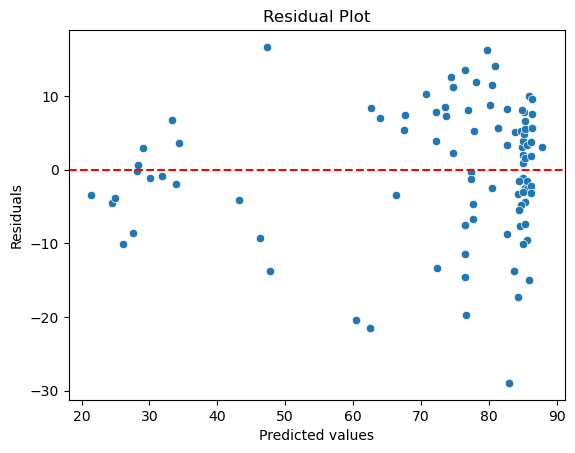

In [ ]:
sns.scatterplot(x=xgb_y_hat_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

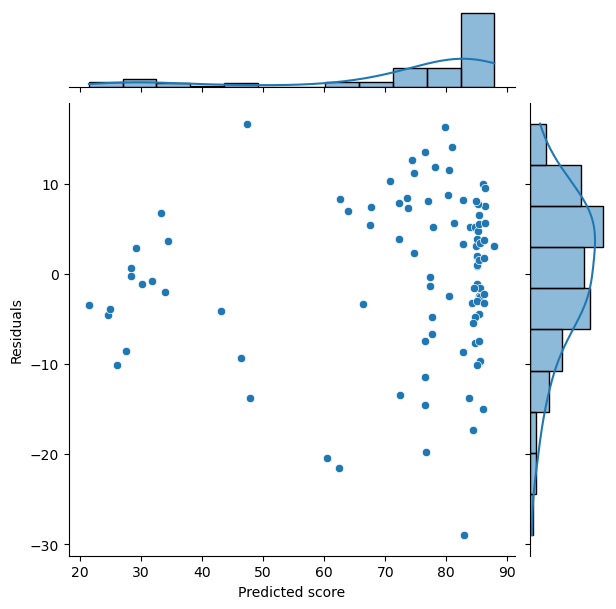

In [ ]:
linreg_grid = sns.JointGrid(x=xgb_y_hat_test, y=residuals)
linreg_grid.plot_joint(sns.scatterplot)
linreg_grid.plot_marginals(sns.histplot, kde=True)
linreg_grid.set_axis_labels(xlabel='Predicted score', ylabel='Residuals')
plt.show()

The model tends to over estimate the sleeping score

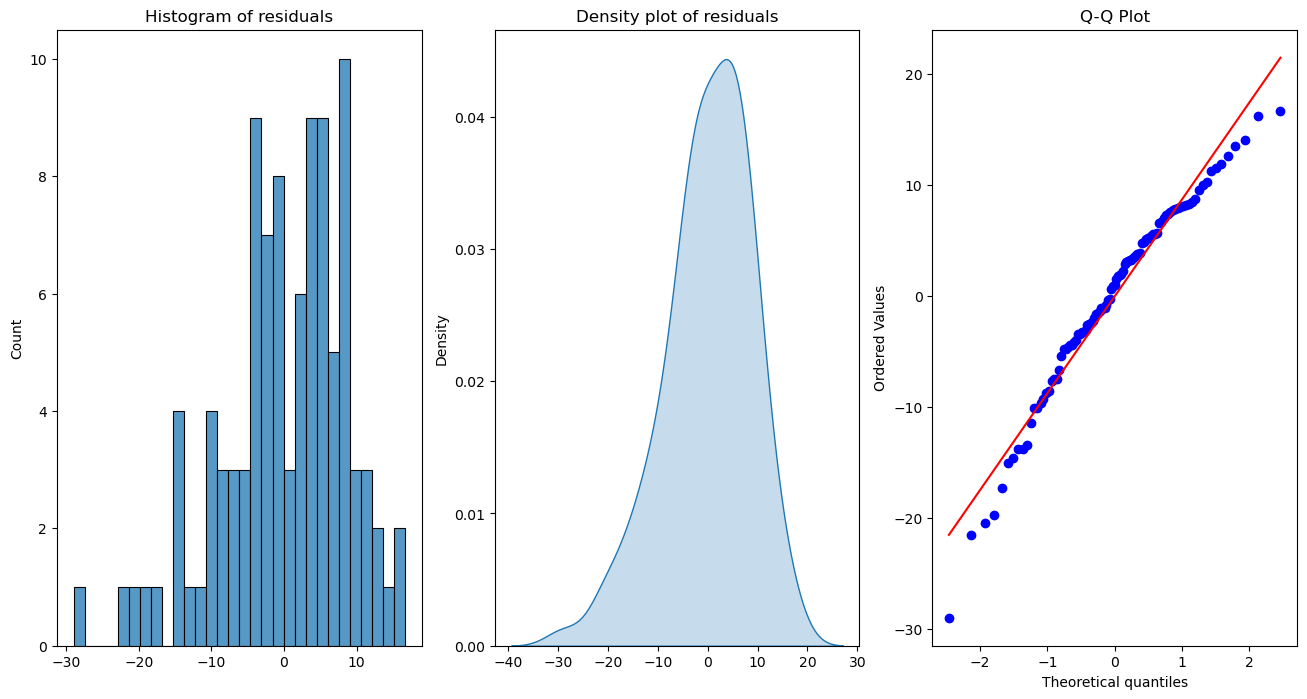

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(x=residuals, bins=30, ax=axs[0])
axs[0].set_title('Histogram of residuals')

sns.kdeplot(x=residuals, fill=True, ax=axs[1])
axs[1].set_title('Density plot of residuals')

stats.probplot(residuals, dist="norm", plot=axs[2])
axs[2].set_title('Q-Q Plot')


plt.show()

In [ ]:
print('Residuals metrics : ')
print(f"Mean : {residuals.mean()}")
print(f"Median : {np.median(residuals)}")
print(f"Standard deviation : {np.std(residuals)}")
print(f"Max : {residuals.max()}")
print(f"Min : {residuals.min()}")
print(f"25th Quartile : {np.quantile(residuals, q=0.25)}")
print(f"75th Quartile : {np.quantile(residuals, q=0.75)}")

print(f"\nBorns for 95% values (between 2 standard deviations)")
print(f"Lower bound : {residuals.mean() - 2*np.std(residuals)}")
print(f"Upper bound : {residuals.mean() + 2*np.std(residuals)}")

Residuals metrics : 
Mean : -0.008188077718904703
Median : 0.9741058349609375
Standard deviation : 8.684411214105918
Max : 16.676971435546875
Min : -28.96478271484375
25th Quartile : -4.419029235839844
75th Quartile : 6.580970764160156

Borns for 95% values (between 2 standard deviations)
Lower bound : -17.37701050593074
Upper bound : 17.36063435049293


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

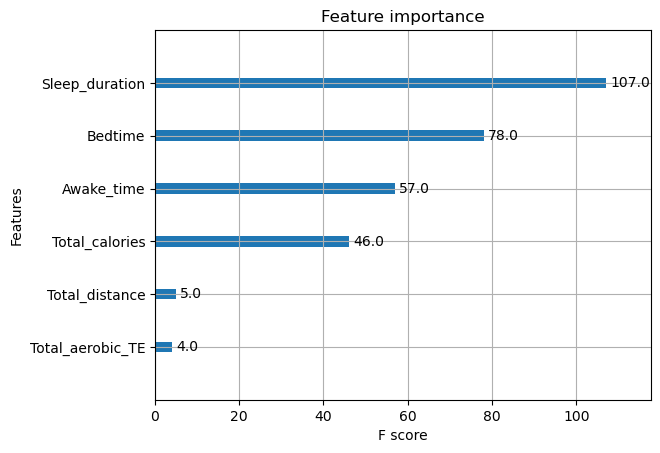

In [ ]:
xgboost.plot_importance(xgb)

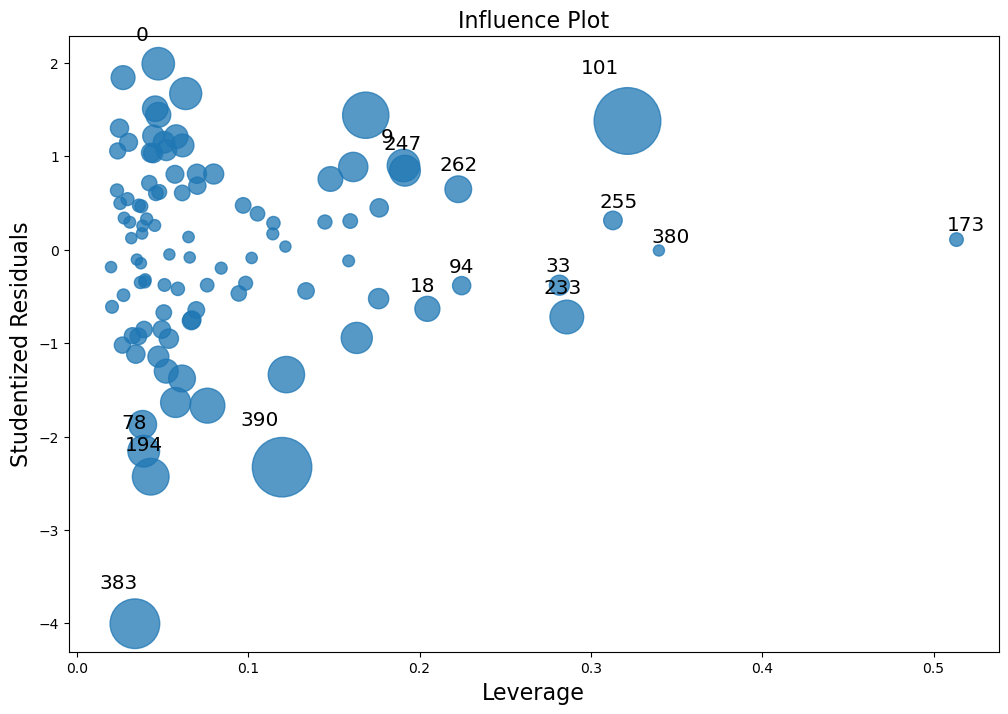

In [ ]:
import statsmodels.api as sm

# Add a constant to the model (required for statsmodels)
X_test_sm = sm.add_constant(X_test)

# Fit the model
model_sm = sm.OLS(y_test, X_test_sm).fit()


# Influence and leverage plots
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.influence_plot(model_sm, ax=ax, criterion="cooks")
plt.show()

In [ ]:
# Add a constant term for the intercept
X_sm = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X_sm).fit()

# Get influence measures
influence = model.get_influence()

# Cook's distance
cooks_d = influence.cooks_distance[0]

# Leverage
leverage = influence.hat_matrix_diag

# Studentized residuals
studentized_residuals = influence.resid_studentized_internal

n = len(df_work)
p = X_sm.shape[1] - 1  # number of predictors

# Thresholds
cooks_d_threshold = 4 / n
leverage_threshold = 2 * (p + 1) / n
studentized_residuals_threshold = 2

# Identify high influential points
high_influential_points = (cooks_d > cooks_d_threshold) | \
                          (leverage > leverage_threshold) | \
                          (abs(studentized_residuals) > studentized_residuals_threshold)

# Get indices of high influential points
high_influential_indices = X.index[high_influential_points]

# Extract high influential data points
high_influential_data = X.loc[high_influential_indices]

print("High Influential Points:")
high_influential_data


High Influential Points:


,Sleep_duration,Bedtime,Total_calories,Awake_time,N_activities,Total_duration,Total_distance,Total_aerobic_TE
5,8.600000,22.200000,2401,14.766667,1.0,7.371667,1.10,0.7
7,1.550000,7.883333,3945,23.850000,0.0,0.000000,0.00,0.0
8,5.300000,4.500000,5991,18.883333,0.0,0.000000,0.00,0.0
9,3.900000,3.216667,5149,15.716667,0.0,0.000000,0.00,0.0
11,10.733333,22.950000,3732,16.700000,1.0,44.166667,8.25,3.8
...,...,...,...,...,...,...,...,...
384,8.833333,1.350000,4335,16.700000,0.0,0.000000,0.00,0.0
387,9.716667,0.300000,2484,12.666667,0.0,0.000000,0.00,0.0
389,6.050000,3.183333,3597,16.783333,1.0,83.383333,15.00,4.0
391,5.650000,2.500000,2794,18.100000,1.0,1.755000,0.32,0.6


In [ ]:
merged = df_work.merge(high_influential_data, on=high_influential_data.columns.tolist(), how='outer', indicator=True)
# Filter rows that are only in df_work to retrieve "normal" rows
not_hid = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')
not_hid

,Score,Sleep_duration,Bedtime,Total_calories,Awake_time,N_activities,Total_duration,Total_distance,Total_aerobic_TE,Bedtime_cluster
0,89.0,8.066667,23.433333,3678,15.994360,0.0,0.000000,0.00,0.0,3
1,41.0,7.100000,3.383333,2807,19.866667,0.0,0.000000,0.00,0.0,1
2,74.0,8.500000,23.133333,2794,12.483333,1.0,20.466667,3.00,2.2,3
3,82.0,8.316667,22.800000,2741,14.466667,0.0,0.000000,0.00,0.0,3
4,79.0,7.216667,23.883333,3546,16.633333,1.0,51.700000,9.65,3.9,3
...,...,...,...,...,...,...,...,...,...,...
396,67.0,8.800000,23.150000,3602,14.700000,0.0,0.000000,0.00,0.0,3
397,82.0,10.100000,21.650000,3078,13.600000,1.0,63.383333,11.23,3.8,3
398,78.0,7.633333,20.983333,2341,12.933333,0.0,0.000000,0.00,0.0,3
399,96.0,8.466667,20.416667,2743,15.333333,1.0,37.750000,6.39,2.7,3


High influential Wilcoxon Mann Whitney test
p_value : 0.0156 -> Statistically different
"Normal data" Wilcoxon Mann Whitney test
p_value : 0.3721 -> Not statistically different


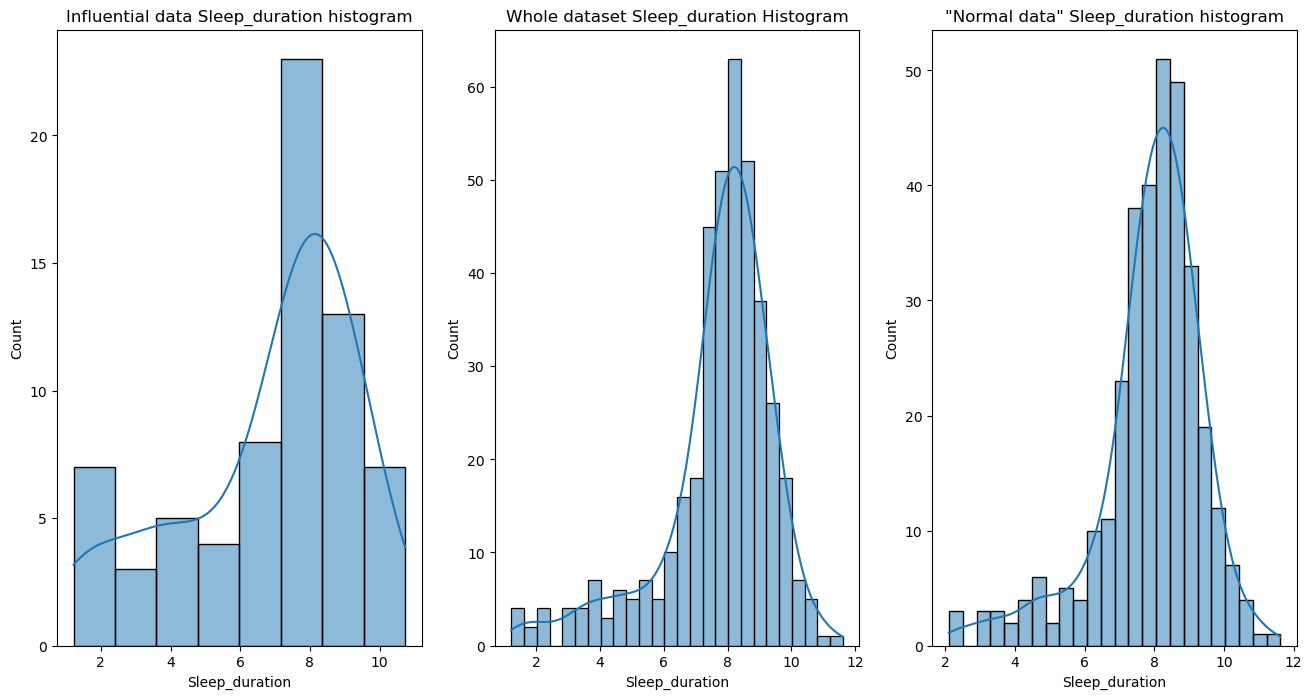

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(data=high_influential_data, x='Sleep_duration', kde=True, ax=axs[0])
axs[0].set_title('Influential data Sleep_duration histogram')

sns.histplot(data=df_work, x='Sleep_duration', kde=True, ax=axs[1])
axs[1].set_title('Whole dataset Sleep_duration Histogram')

sns.histplot(data=not_hid, x='Sleep_duration', kde=True, ax=axs[2])
axs[2].set_title('"Normal data" Sleep_duration histogram')

print_wmh_results(high_influential_data, df_work, not_hid, 'Sleep_duration')

plt.show()

High influential VS whole dataset Wilcoxon Mann Whitney test
p_value : 0.3664 -> Not statistically different

"Normal data" vs whole dataset Wilcoxon Mann Whitney test
p_value : 0.7389 -> Not statistically different


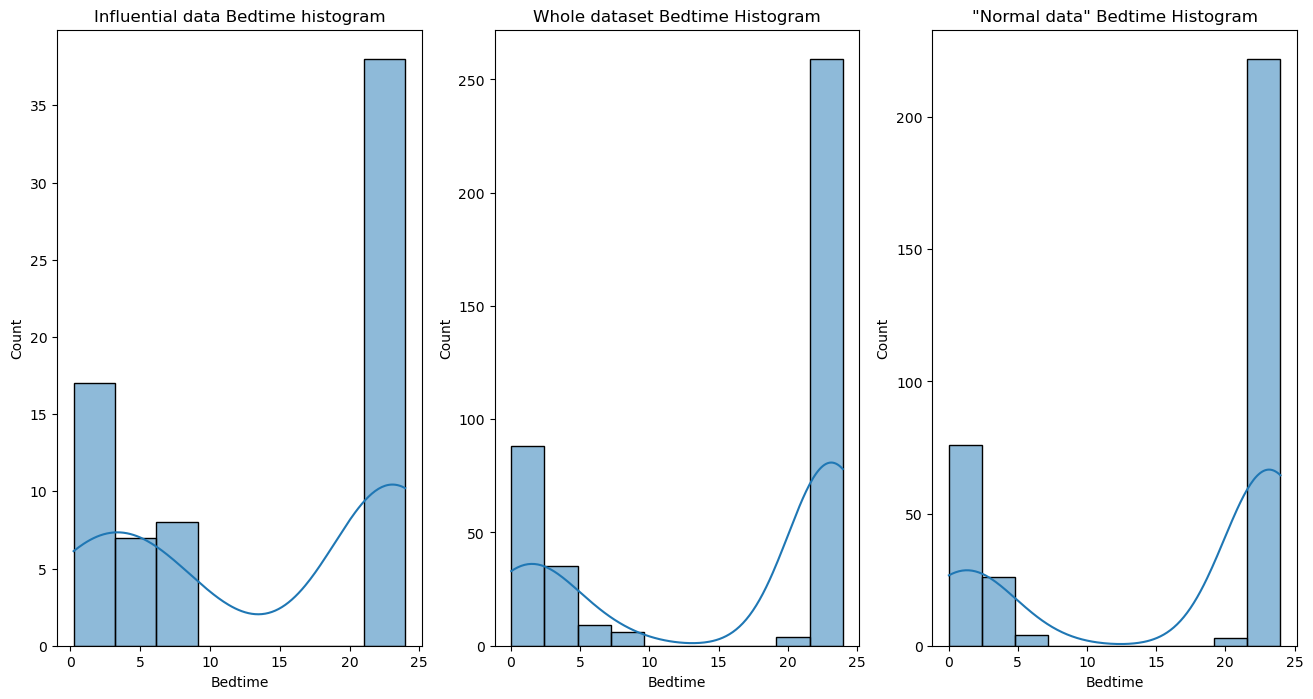

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(data=high_influential_data, x='Bedtime', kde=True, ax=axs[0])
axs[0].set_title('Influential data Bedtime histogram')

sns.histplot(data=df_work, x='Bedtime', kde=True, ax=axs[1])
axs[1].set_title('Whole dataset Bedtime Histogram')

sns.histplot(data=not_hid, x='Bedtime', kde=True, ax=axs[2])
axs[2].set_title('"Normal data" Bedtime Histogram')

print_wmh_results(high_influential_data, df_work, not_hid, 'Bedtime')

plt.show()

High influential VS whole dataset Wilcoxon Mann Whitney test
p_value : 0.0298 -> Statistically different

"Normal data" vs whole dataset Wilcoxon Mann Whitney test
p_value : 0.4226 -> Not statistically different


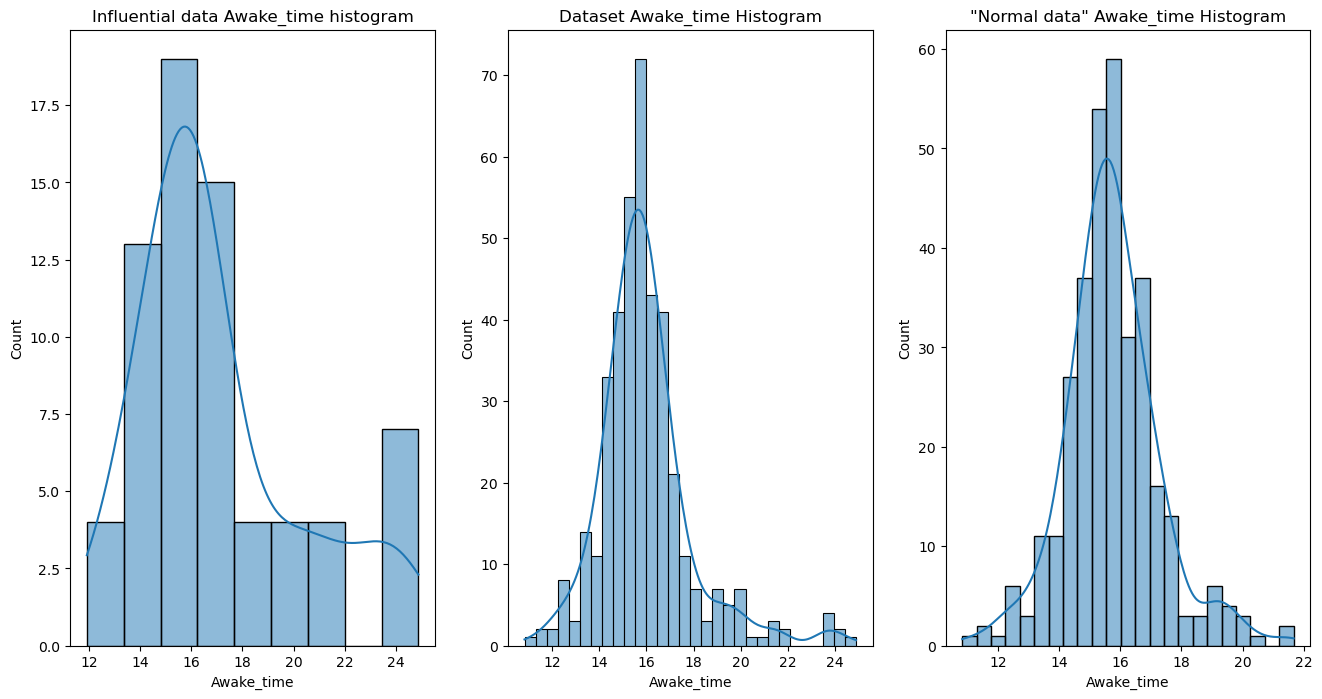

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(data=high_influential_data, x='Awake_time', kde=True, ax=axs[0])
axs[0].set_title('Influential data Awake_time histogram')

sns.histplot(data=df_work, x='Awake_time', kde=True, ax=axs[1])
axs[1].set_title('Dataset Awake_time Histogram')

sns.histplot(data=not_hid, x='Awake_time', kde=True, ax=axs[2])
axs[2].set_title('"Normal data" Awake_time Histogram')

print_wmh_results(high_influential_data, df_work, not_hid, 'Awake_time')

plt.show()

High influential VS whole dataset Wilcoxon Mann Whitney test
p_value : 0.0000 -> Statistically different

"Normal data" vs whole dataset Wilcoxon Mann Whitney test
p_value : 0.0906 -> Not statistically different


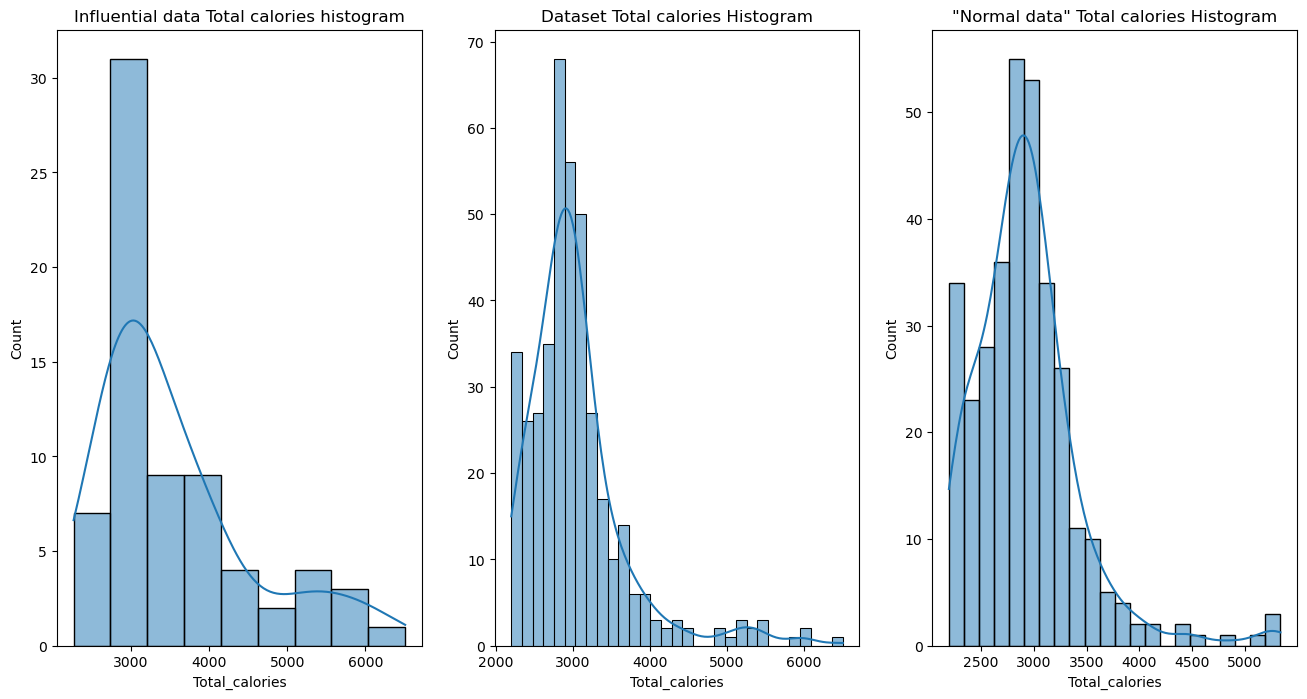

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

sns.histplot(data=high_influential_data, x='Total_calories', kde=True, ax=axs[0])
axs[0].set_title('Influential data Total calories histogram')

sns.histplot(data=df_work, x='Total_calories', kde=True, ax=axs[1])
axs[1].set_title('Dataset Total calories Histogram')

sns.histplot(data=not_hid, x='Total_calories', kde=True, ax=axs[2])
axs[2].set_title('"Normal data" Total calories Histogram')

print_wmh_results(high_influential_data, df_work, not_hid, 'Total_calories')

plt.show()

p_value : 0.0038 -> Statistically different


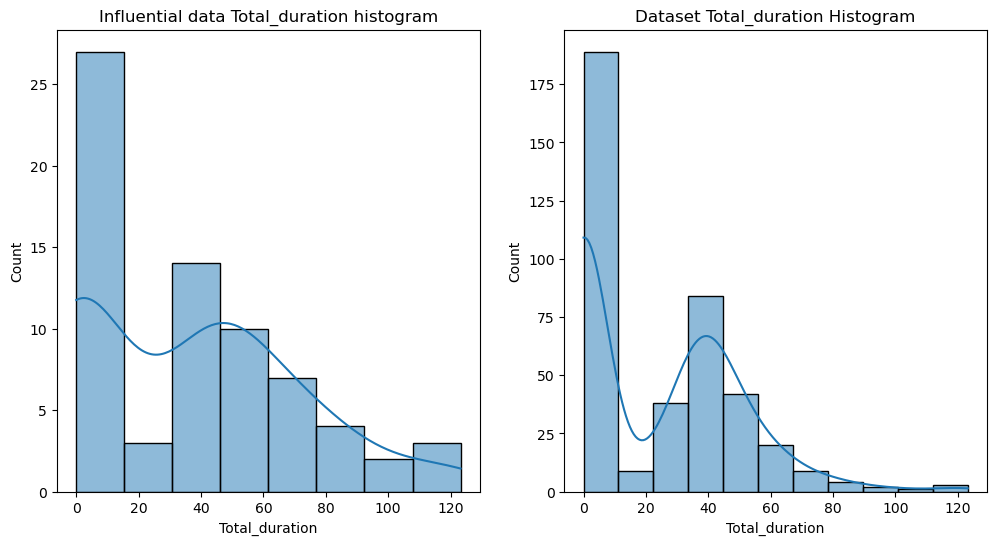

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=high_influential_data, x='Total_duration', kde=True, ax=axs[0])
axs[0].set_title('Influential data Total_duration histogram')

sns.histplot(data=df_work, x='Total_duration', kde=True, ax=axs[1])
axs[1].set_title('Dataset Total_duration Histogram')

pop_duration_mean = df_work['Total_duration'].mean()
t_stat, p_value = stats.ttest_1samp(high_influential_data['Total_duration'], pop_duration_mean)

print(f"p_value : {p_value:.4f} -> Statistically different") if p_value < 0.05 else print(f"p_value : {p_value:.4f} -> Not statistically different")

plt.show()

p_value : 0.0207 -> Statistically different


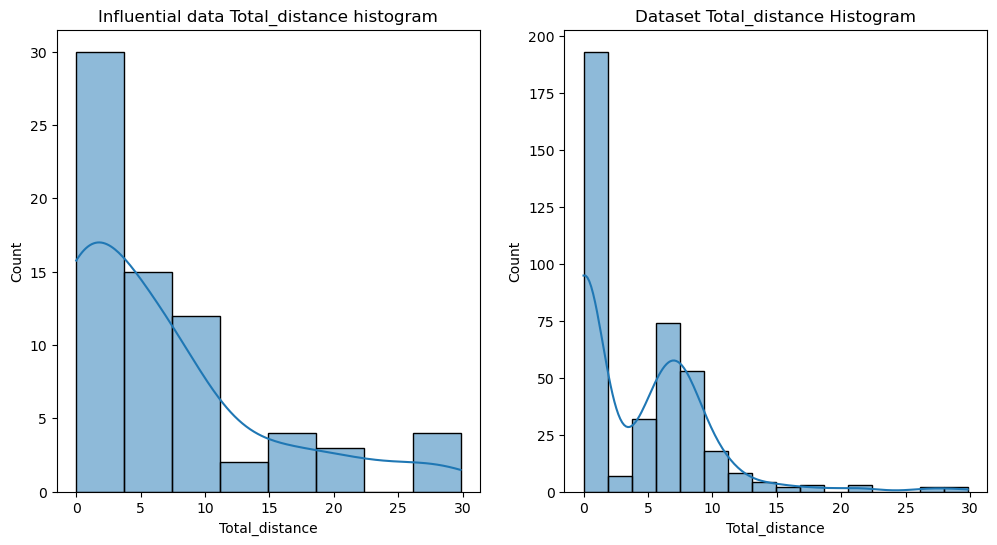

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=high_influential_data, x='Total_distance', kde=True, ax=axs[0])
axs[0].set_title('Influential data Total_distance histogram')

sns.histplot(data=df_work, x='Total_distance', kde=True, ax=axs[1])
axs[1].set_title('Dataset Total_distance Histogram')

pop_distance_mean = df_work['Total_distance'].mean()
t_stat, p_value = stats.ttest_1samp(high_influential_data['Total_distance'], pop_distance_mean)

print(f"p_value : {p_value:.4f} -> Statistically different") if p_value < 0.05 else print(f"p_value : {p_value:.4f} -> Not statistically different")

plt.show()

p_value : 0.0066 -> Statistically different


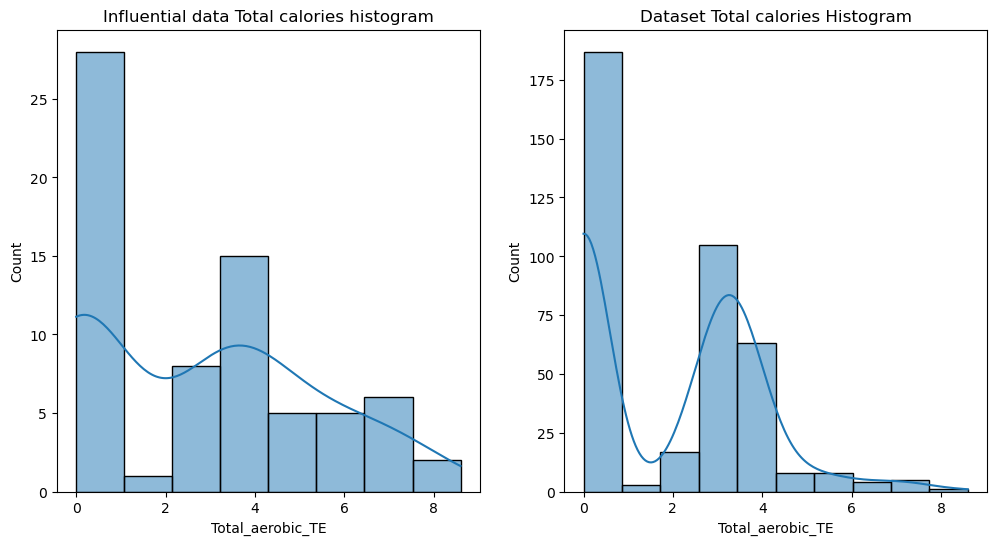

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=high_influential_data, x='Total_aerobic_TE', kde=True, ax=axs[0])
axs[0].set_title('Influential data Total calories histogram')

sns.histplot(data=df_work, x='Total_aerobic_TE', kde=True, ax=axs[1])
axs[1].set_title('Dataset Total calories Histogram')

pop_TE_mean = df_work['Total_aerobic_TE'].mean()
t_stat, p_value = stats.ttest_1samp(high_influential_data['Total_aerobic_TE'], pop_TE_mean)

print(f"p_value : {p_value:.4f} -> Statistically different") if p_value < 0.05 else print(f"p_value : {p_value:.4f} -> Not statistically different")


plt.show()

In [ ]:
high_influential_data.columns.tolist()

['Sleep_duration',
 'Bedtime',
 'Total_calories',
 'Awake_time',
 'N_activities',
 'Total_duration',
 'Total_distance',
 'Total_aerobic_TE']

In [ ]:
merged = df_work.merge(high_influential_data, on=high_influential_data.columns.tolist(), how='outer', indicator=True)

# Filter rows that are only in A
not_hid = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')
not_hid

,Score,Sleep_duration,Bedtime,Total_calories,Awake_time,N_activities,Total_duration,Total_distance,Total_aerobic_TE,Bedtime_cluster
0,89.0,8.066667,23.433333,3678,15.994360,0.0,0.000000,0.00,0.0,3
1,41.0,7.100000,3.383333,2807,19.866667,0.0,0.000000,0.00,0.0,1
2,74.0,8.500000,23.133333,2794,12.483333,1.0,20.466667,3.00,2.2,3
3,82.0,8.316667,22.800000,2741,14.466667,0.0,0.000000,0.00,0.0,3
4,79.0,7.216667,23.883333,3546,16.633333,1.0,51.700000,9.65,3.9,3
...,...,...,...,...,...,...,...,...,...,...
396,67.0,8.800000,23.150000,3602,14.700000,0.0,0.000000,0.00,0.0,3
397,82.0,10.100000,21.650000,3078,13.600000,1.0,63.383333,11.23,3.8,3
398,78.0,7.633333,20.983333,2341,12.933333,0.0,0.000000,0.00,0.0,3
399,96.0,8.466667,20.416667,2743,15.333333,1.0,37.750000,6.39,2.7,3


In [ ]:
pop_TE_mean = df_work['Total_aerobic_TE'].mean()
t_stat, p_value = stats.ttest_1samp(not_hid['Total_aerobic_TE'], pop_TE_mean)

print(f"p_value : {p_value:.4f} -> Statistically different") if p_value < 0.05 else print(f"p_value : {p_value:.4f} -> Not statistically different")

p_value : 0.0555 -> Not statistically different
